In [2]:
import io, os, re, math, glob, csv, pickle, random, requests, shutil
import tarfile, tempfile
from zipfile import ZipFile

from subprocess import Popen, PIPE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile
from IPython.display import Audio
import librosa
import soundfile as sf
from SpecAugment import spec_augment_tensorflow

import tensorflow as tf
from tensorflow.keras import regularizers
import keras
from keras.regularizers import l2

import torch
import torchaudio

import sed_eval
import dcase_util

2023-11-07 06:37:46.830423: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-07 06:37:47.153384: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 06:37:48.134492: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned en

In [3]:
# Parametersa
generator_params = {'dim': (1, ),
          'batch_size': 32,
          'epoch_size': 100,
          'n_classes': 1,
          'shuffle': True}
params = {'aud_win_len' : 2.56,
          'aud_hop_len' : 1.00,
          'n_mels' : 40,
          'mel_hop_len' : 441,
          'mel_win_len' : 1764,
          'mel_n_fft' : 2048,
          'sample_rate' : 44100}

# 잘게 쪼개서 넣는 예시

In [1]:
# define necessary utility functions

# parameters
buffer_len = 256

# test signal
input_wav = "data/wav/003n.wav"
samp_freq, signal = wavfile.read(input_wav)
signal = signal[:,]  # get first channel
n_buffers = len(signal)//buffer_len
data_type = signal.dtype

print("Sampling frequency : %d Hz" % samp_freq)
print("Data type          : %s" % signal.dtype)

# allocate input and output buffers
input_buffer = np.zeros(buffer_len, dtype=data_type)
output_buffer = np.zeros(buffer_len, dtype=data_type)

# state variables
def init():

    # declare variables used in `process`
    # global

    # define variables, lookup tables

    return

Sampling frequency : 44100 Hz
Data type          : int16


/tmp/ipykernel_848/3160318897.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samp_freq, signal = wavfile.read(input_wav)


In [2]:
# the process function!
def process(input_buffer, output_buffer, buffer_len):

    # specify global variables modified here
    # global

    # process one sample at a time
    for n in range(buffer_len):

        # passthrough
        output_buffer[n] = input_buffer[n]

In [ ]:
"""
Nothing to touch after this!
"""
init()
# simulate block based processing
signal_proc = np.zeros(n_buffers*buffer_len, dtype=data_type)
for k in range(n_buffers):

    # index the appropriate samples
    input_buffer = signal[k*buffer_len:(k+1)*buffer_len]
    process(input_buffer, output_buffer, buffer_len)
    signal_proc[k*buffer_len:(k+1)*buffer_len] = output_buffer

# write to WAV
#wavfile.write("speech_mod.wav", samp_freq, signal_proc)

In [35]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show()

In [14]:
signal.shape

(926411, 2)

In [11]:
waveform, sr = torchaudio.load(input_wav)

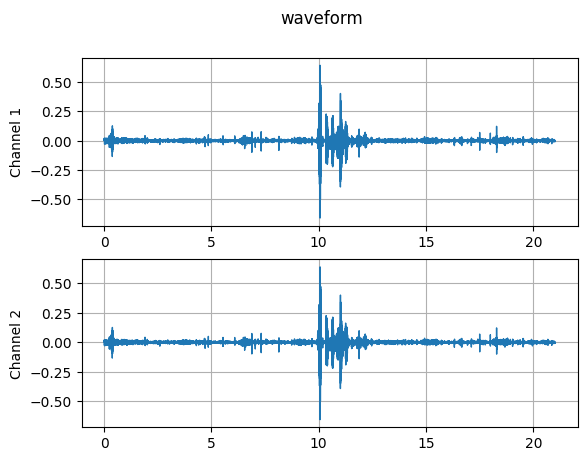

In [22]:
plot_waveform(waveform, sr)

In [13]:
waveform.shape

torch.Size([2, 926411])

/tmp/ipykernel_848/1302390601.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plot_waveform(torch.tensor(input_buffer).view(1,-1), sr)


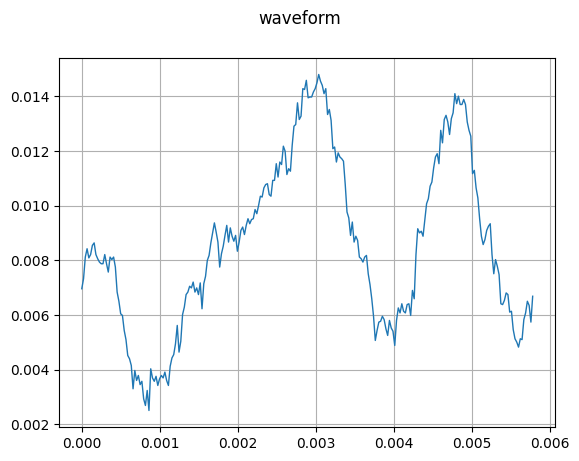

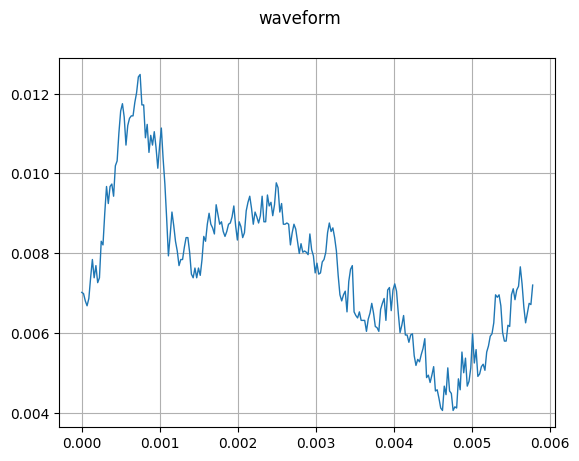

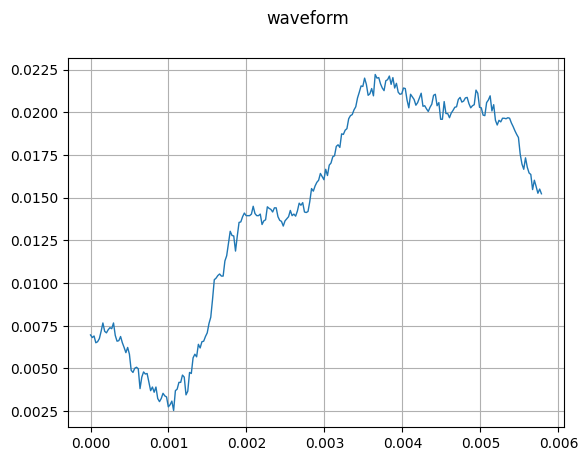

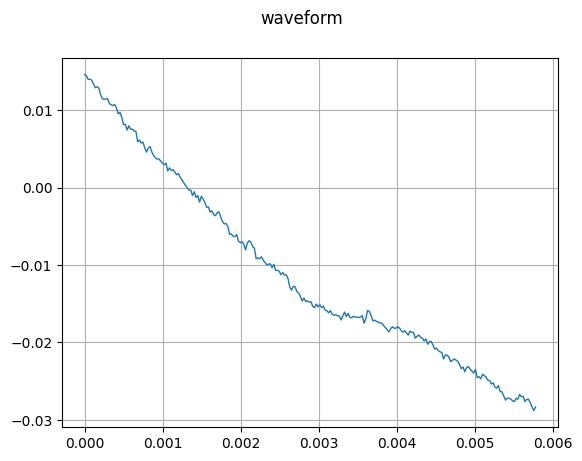

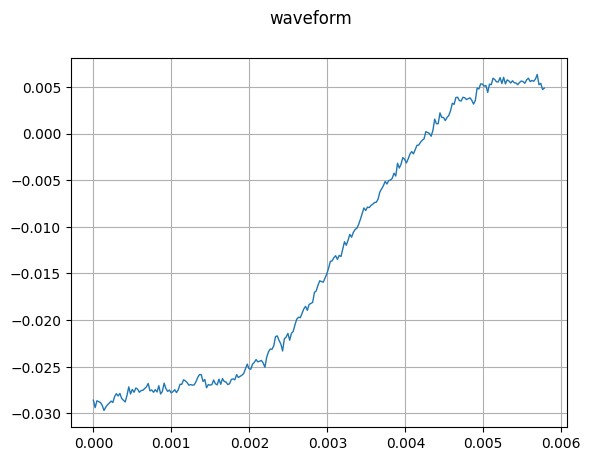

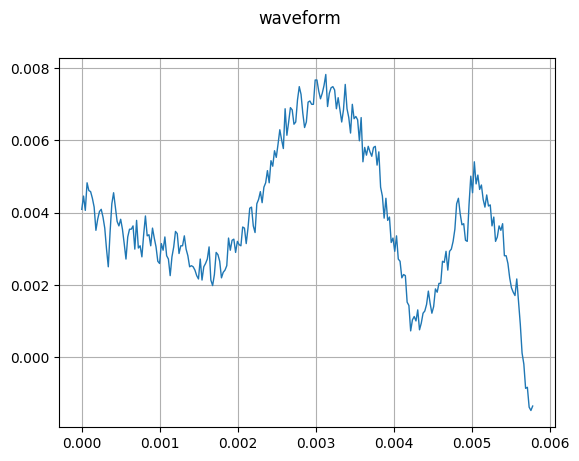

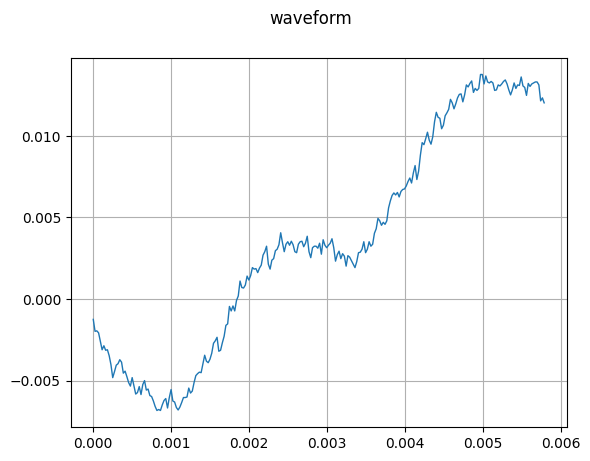

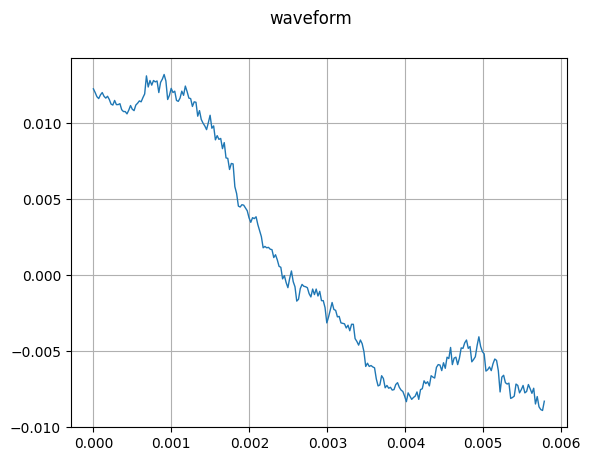

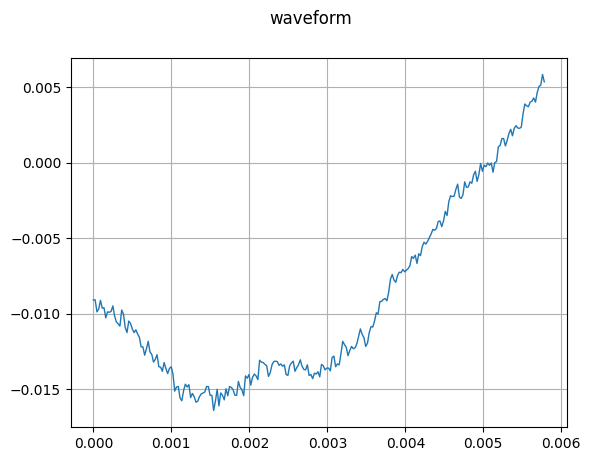

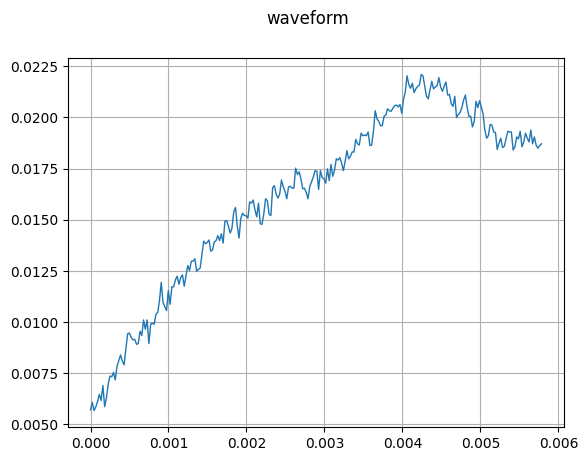

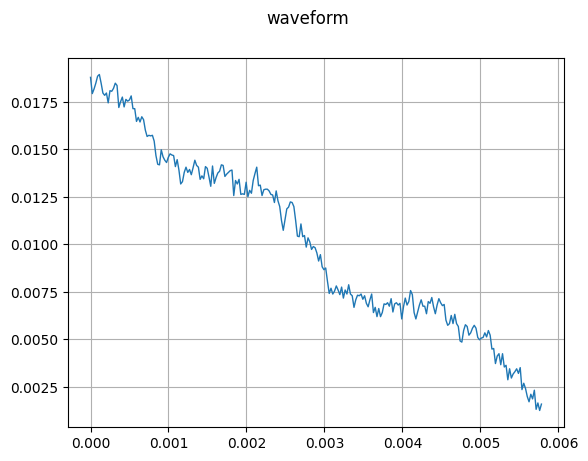

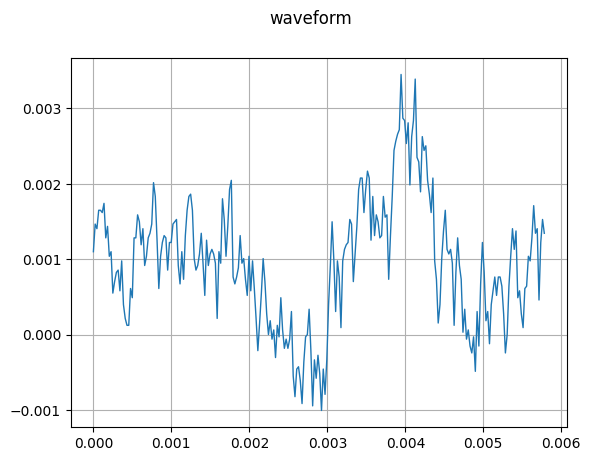

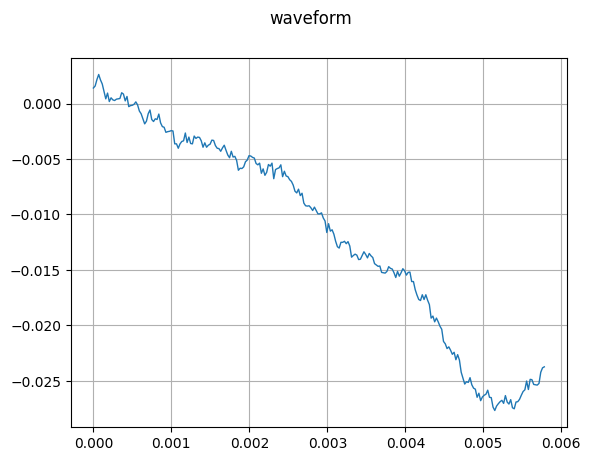

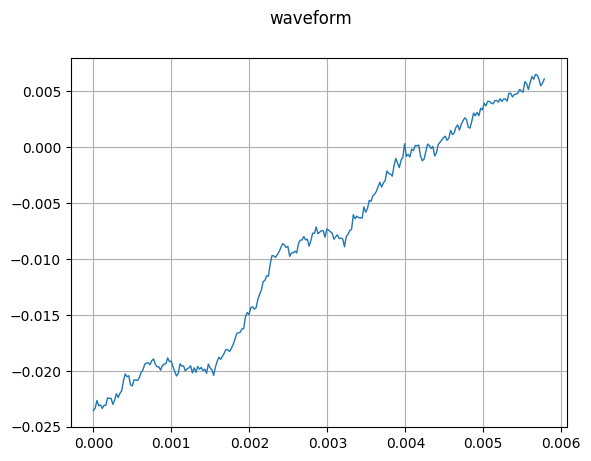

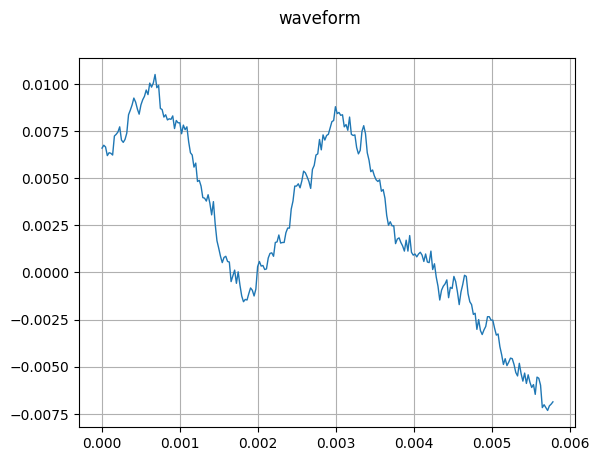

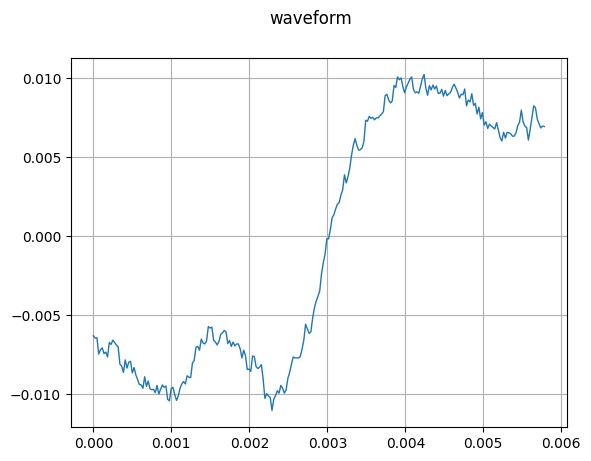

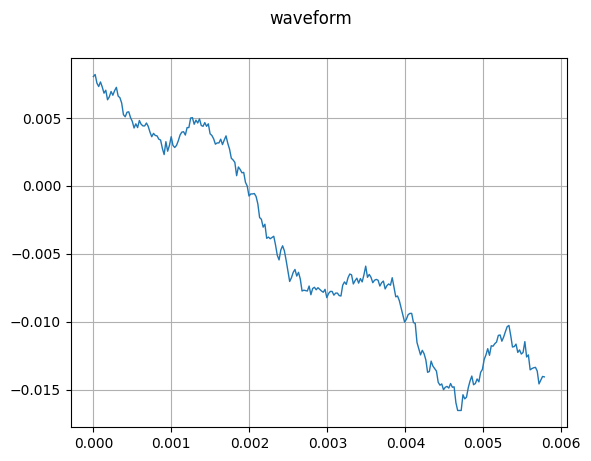

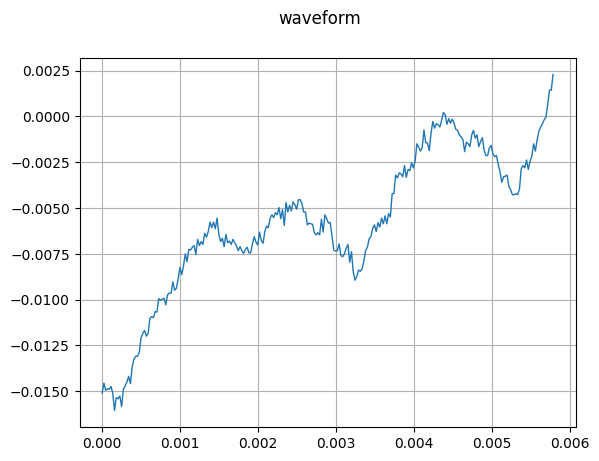

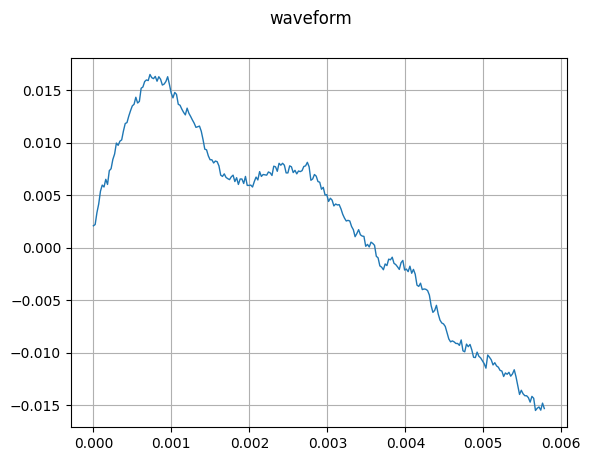

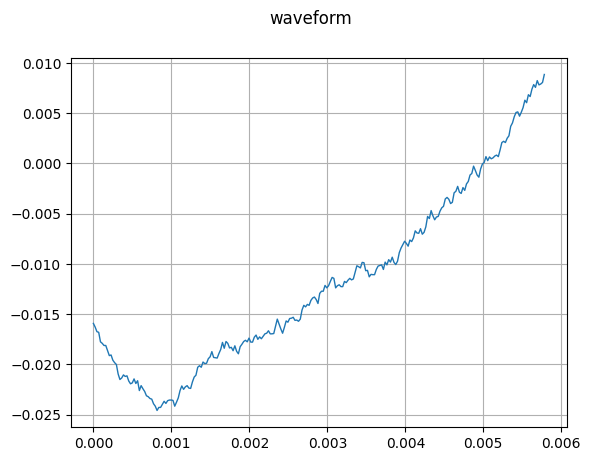

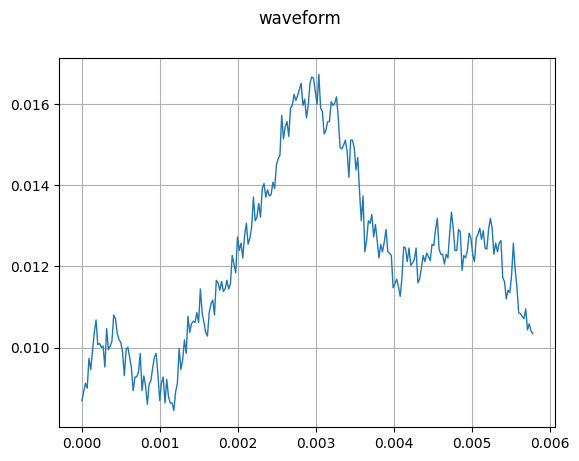

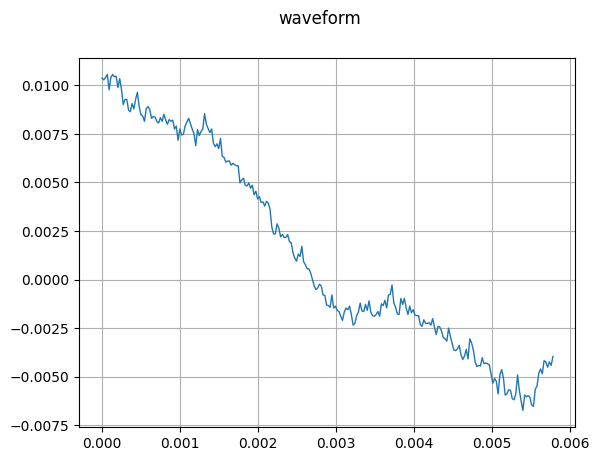

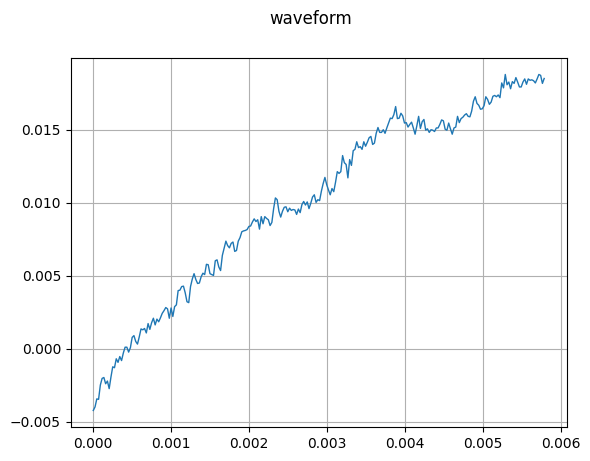

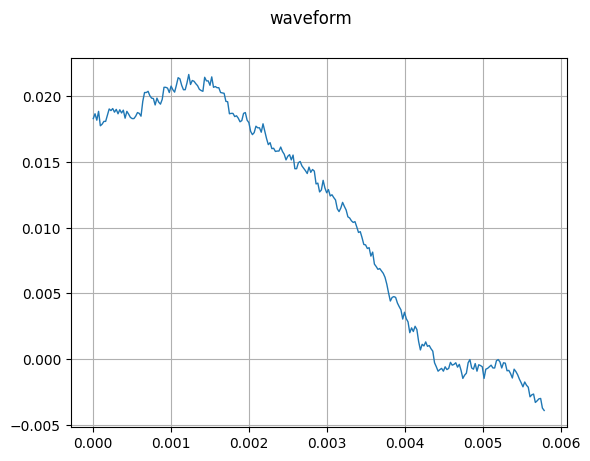

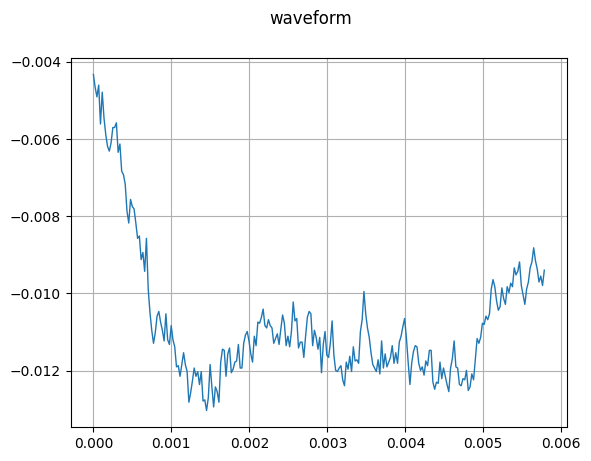

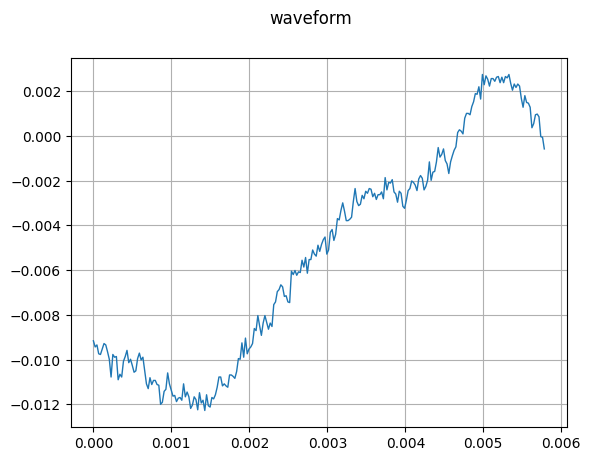

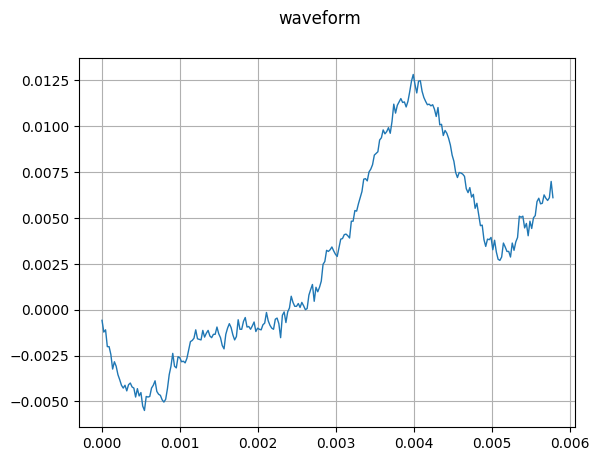

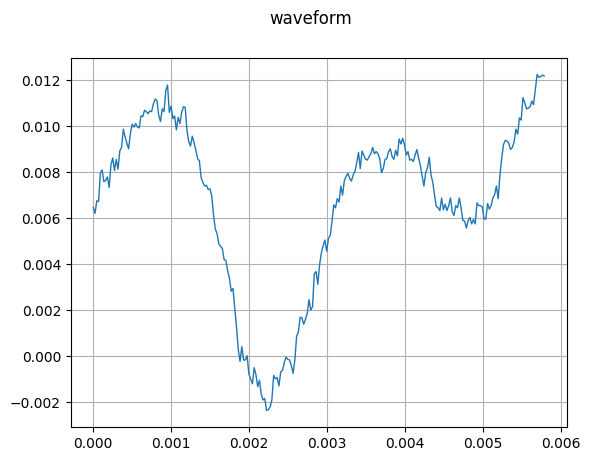

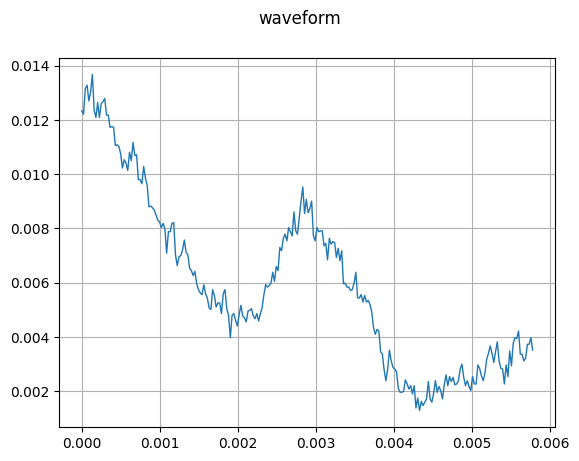

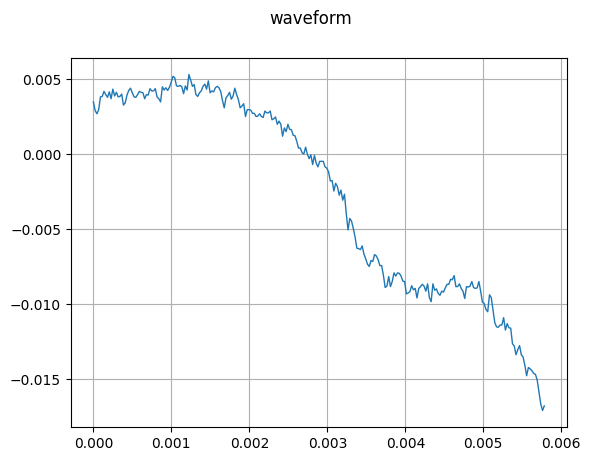

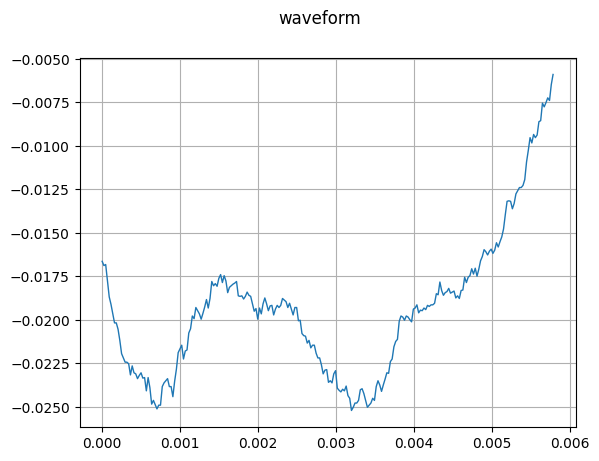

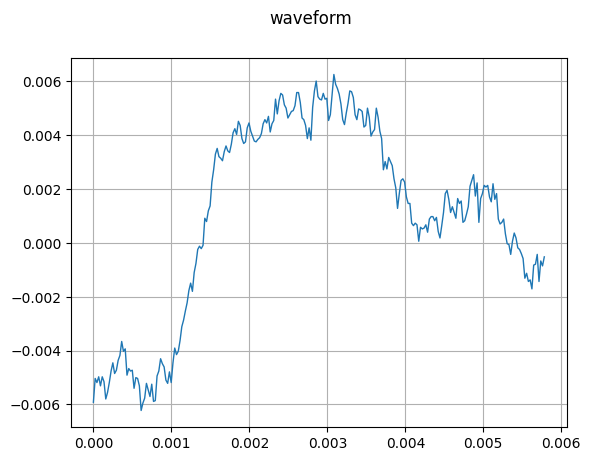

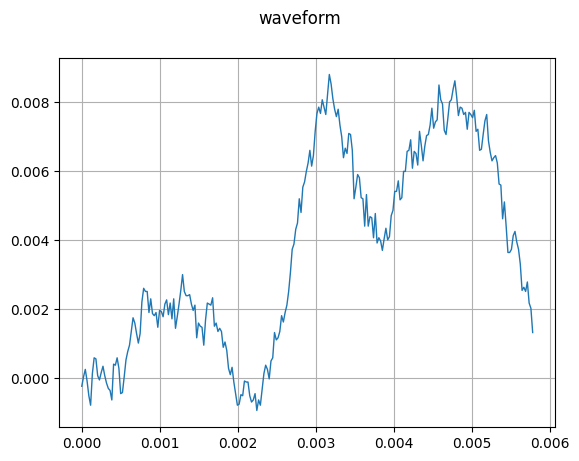

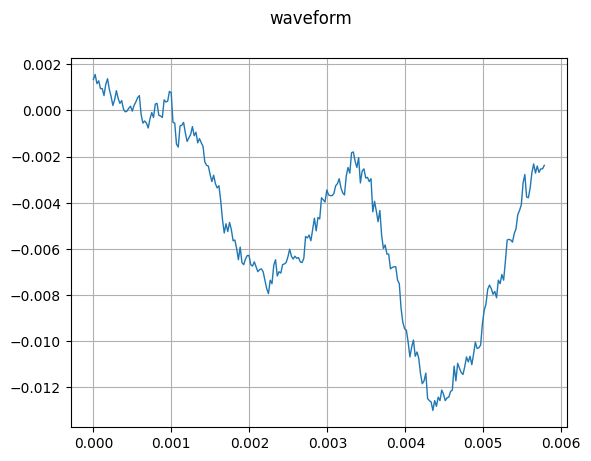

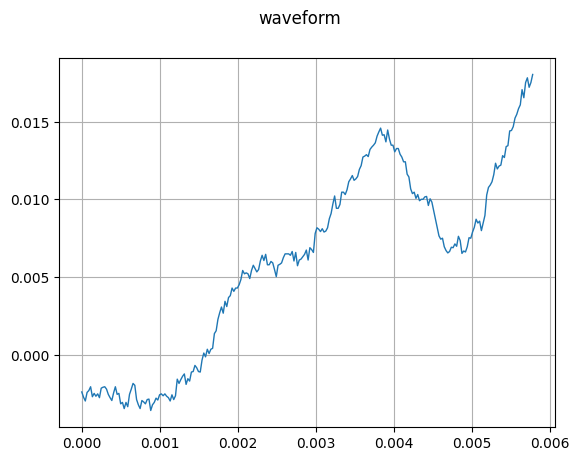

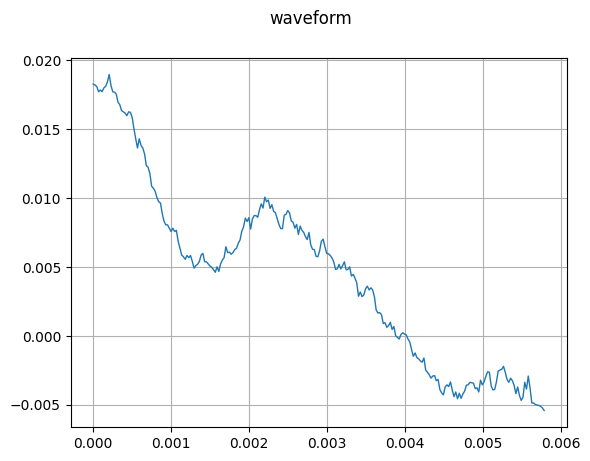

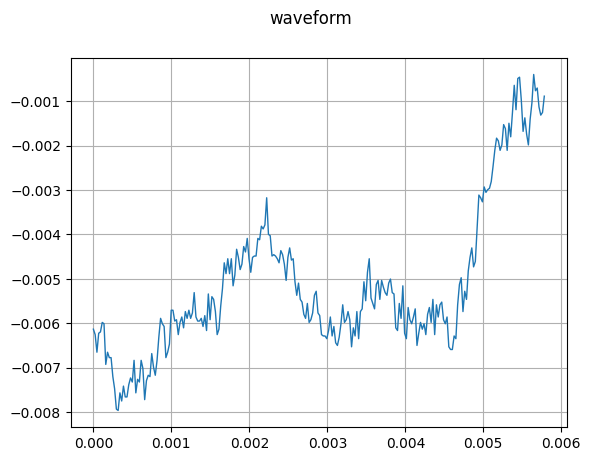

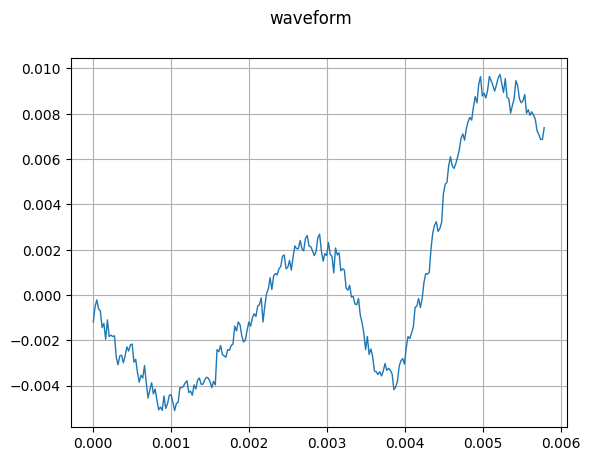

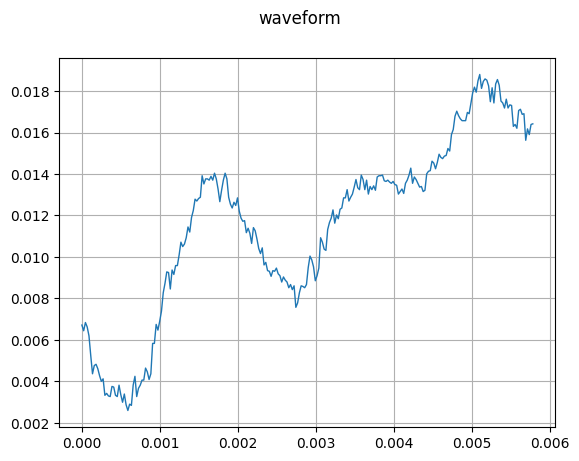

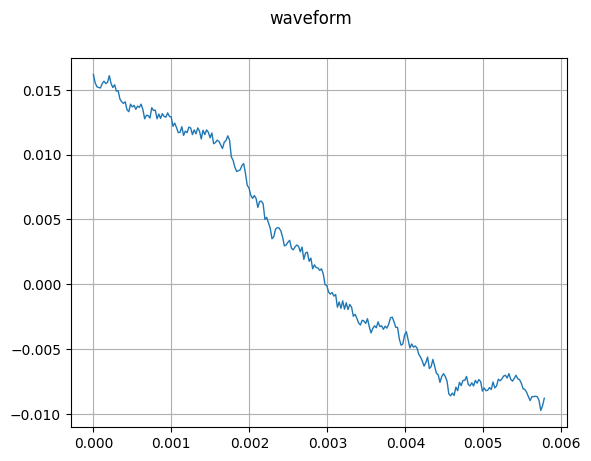

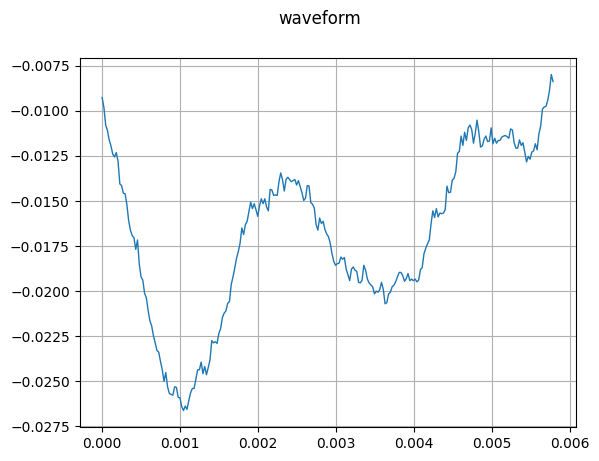

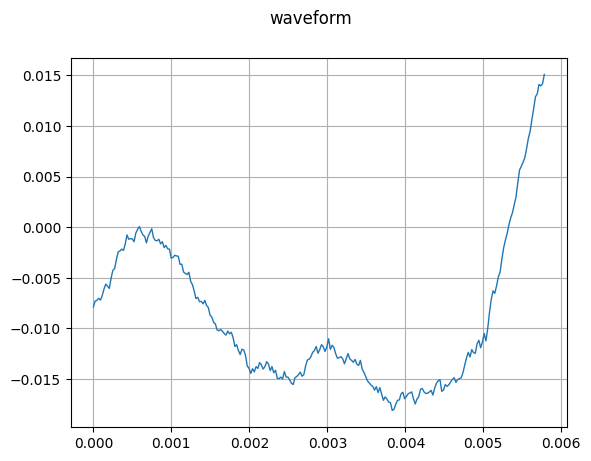

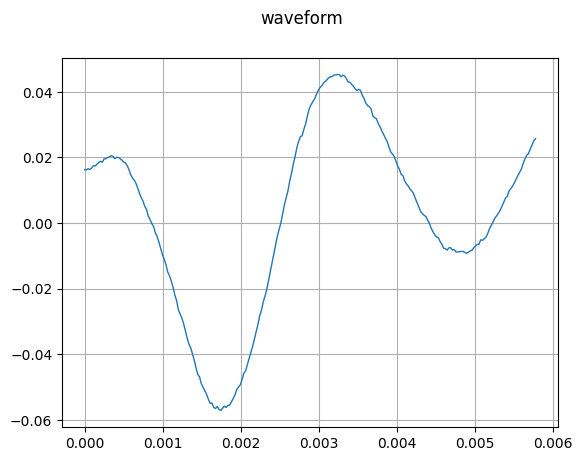

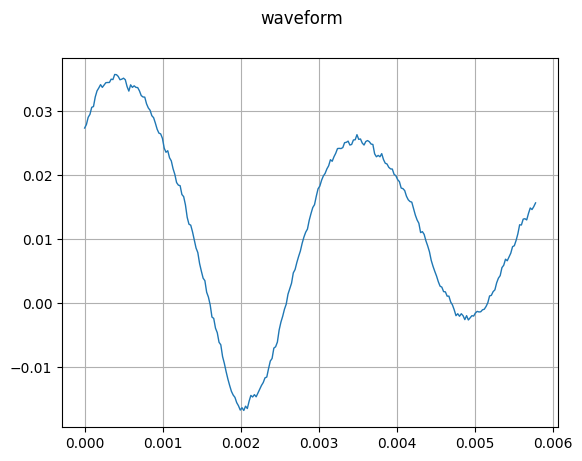

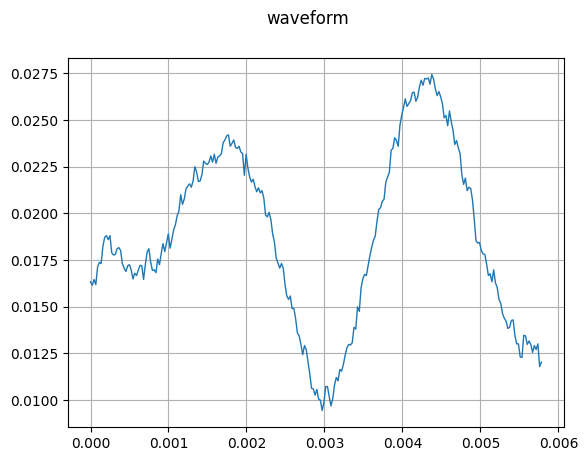

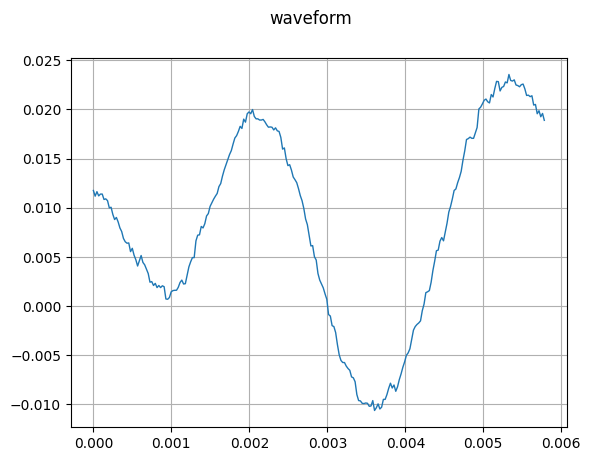

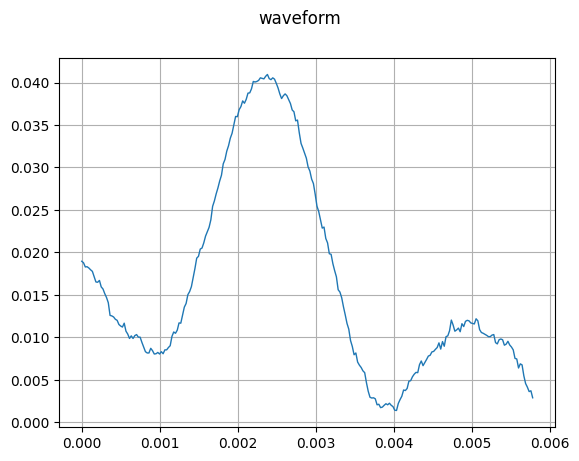

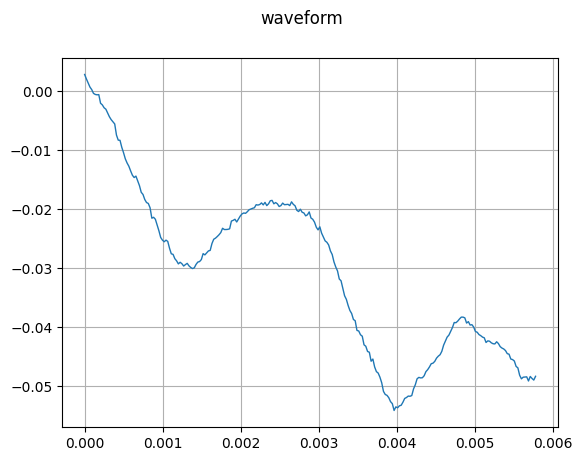

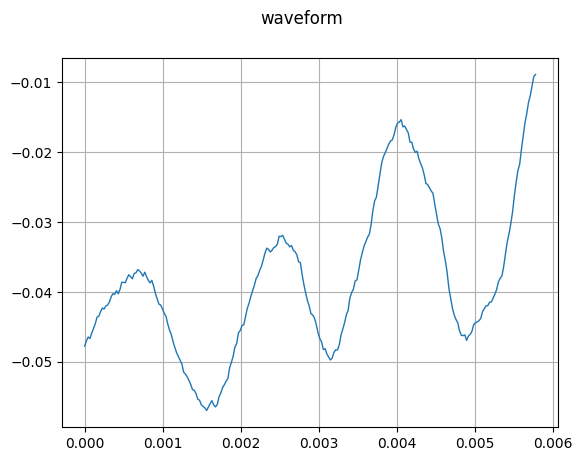

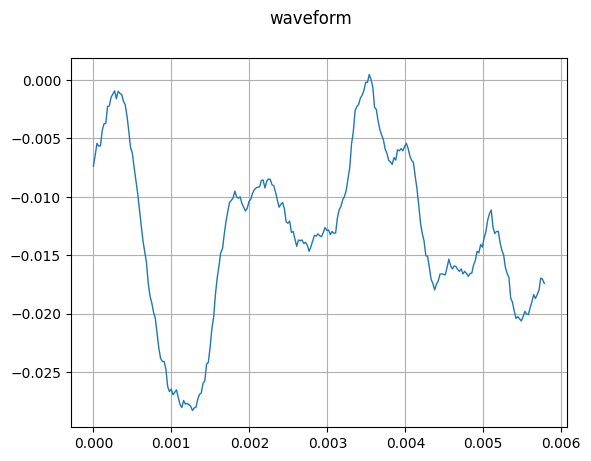

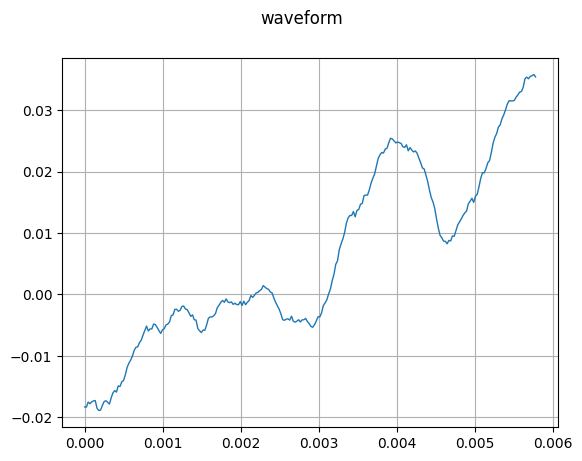

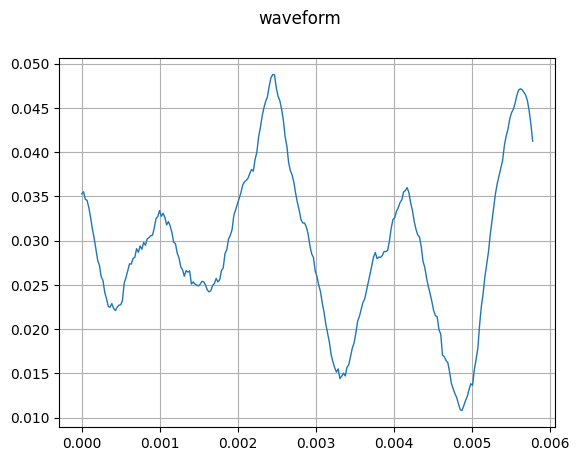

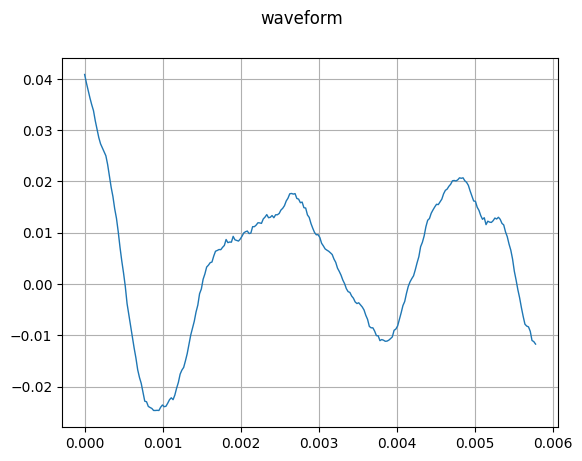

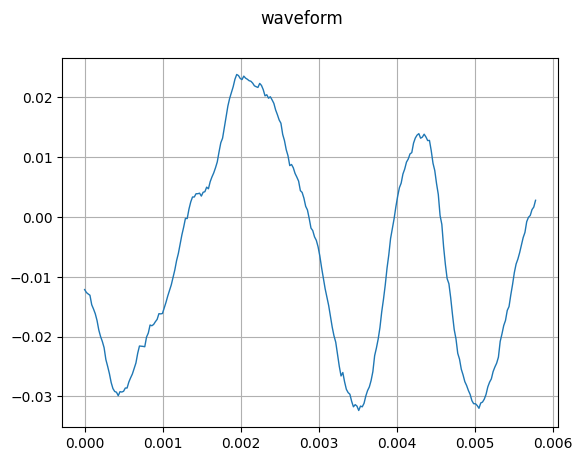

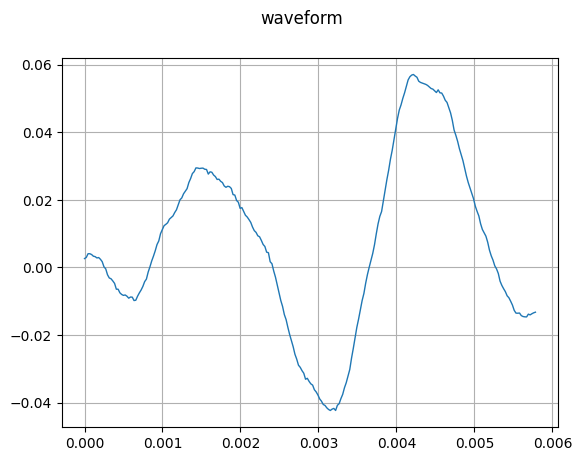

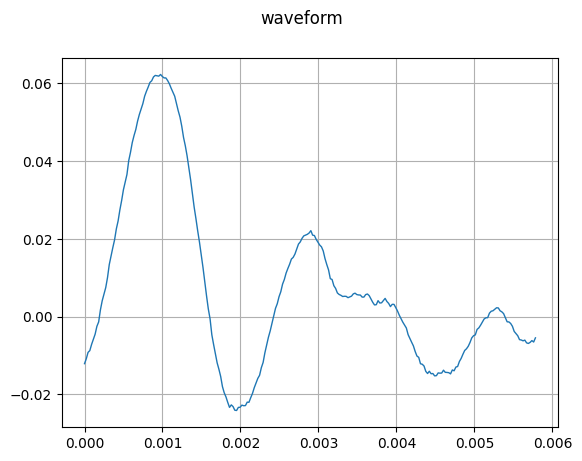

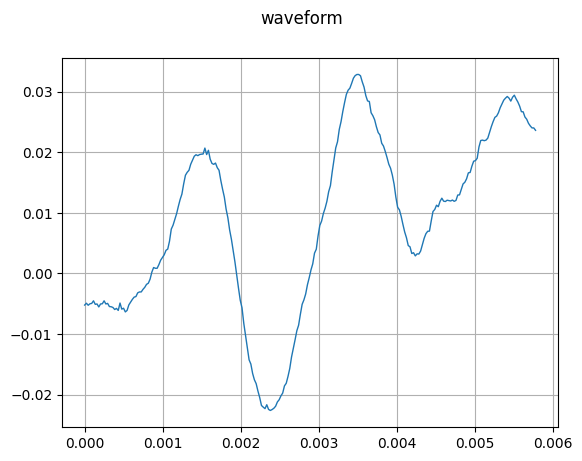

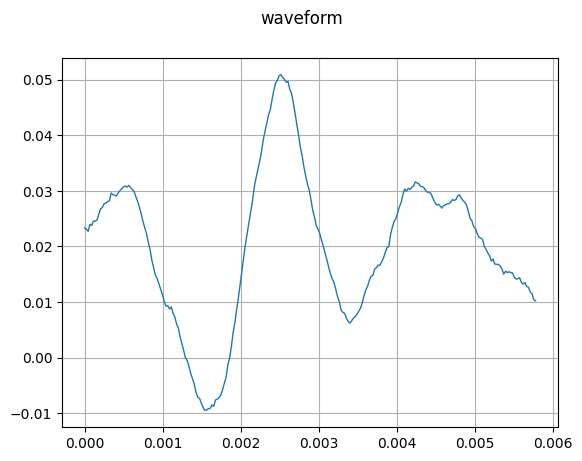

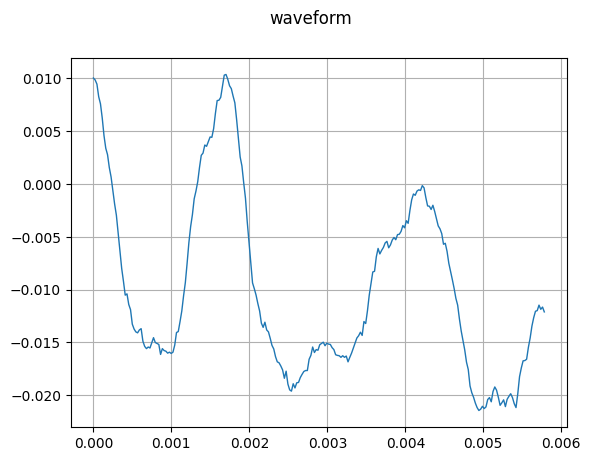

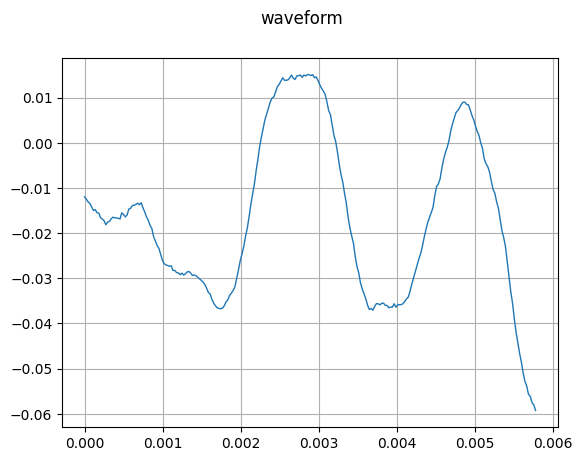

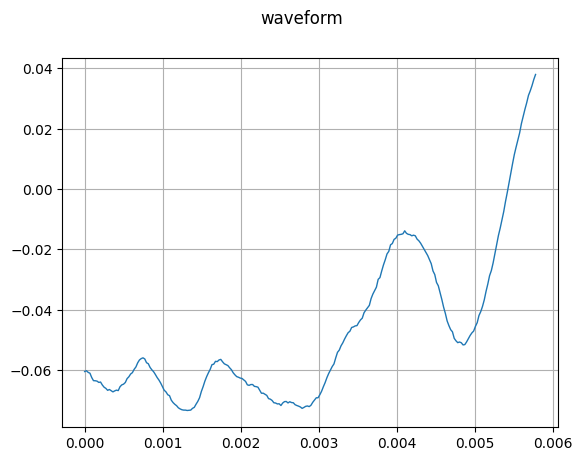

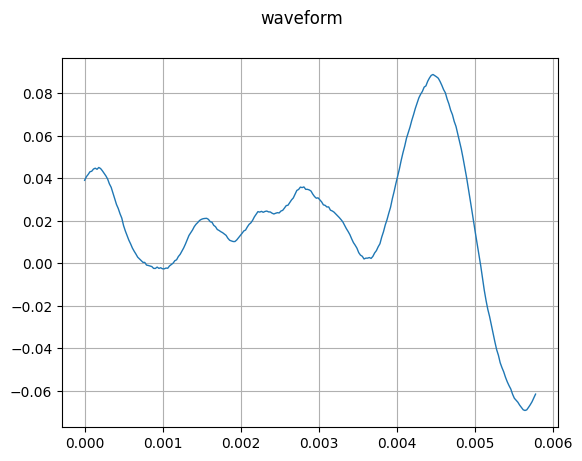

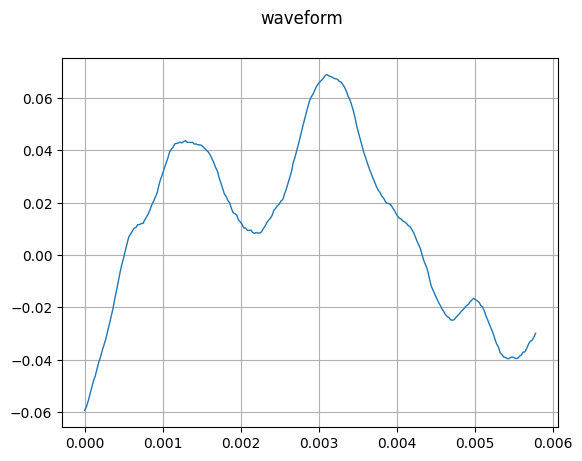

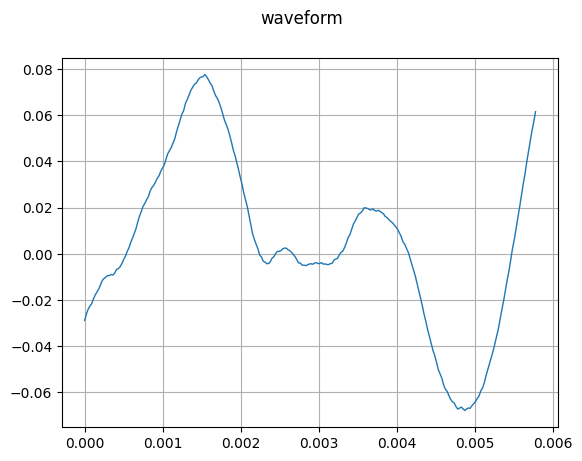

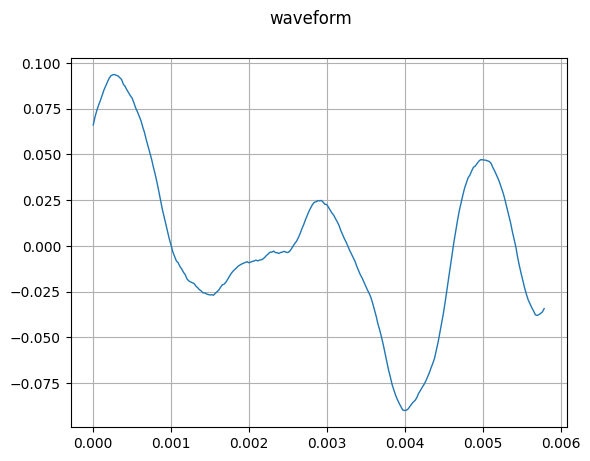

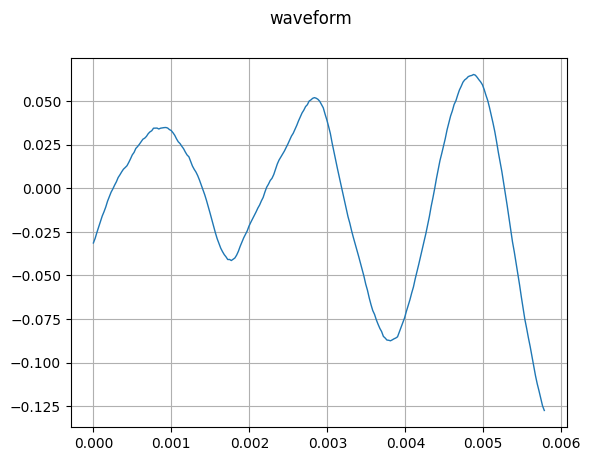

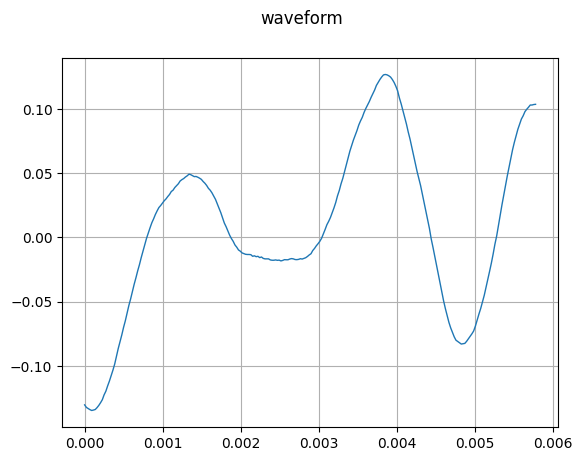

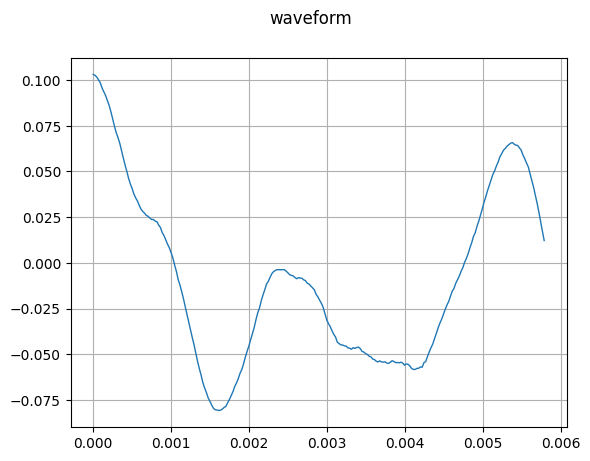

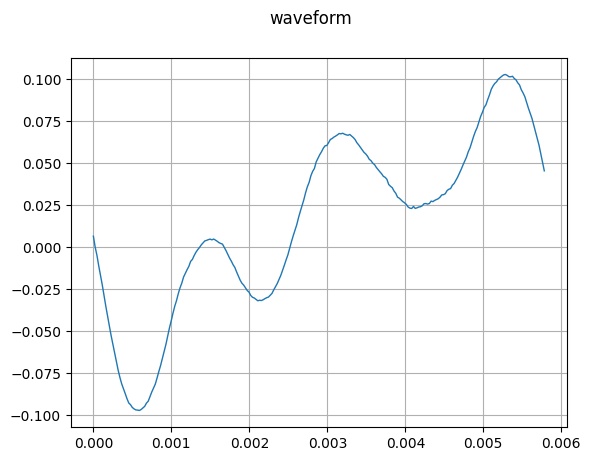

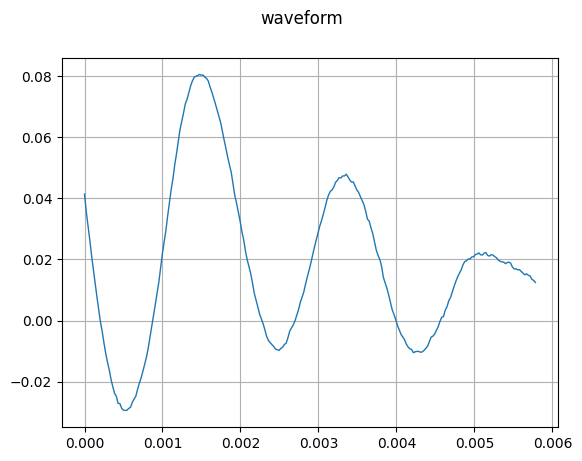

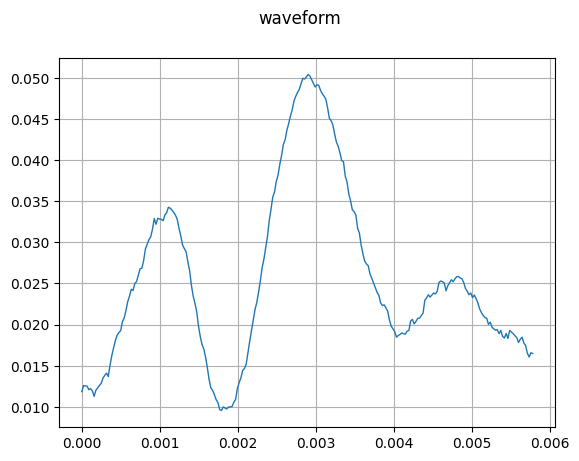

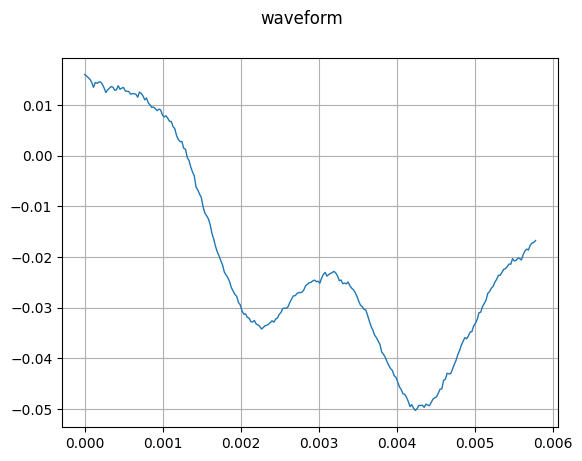

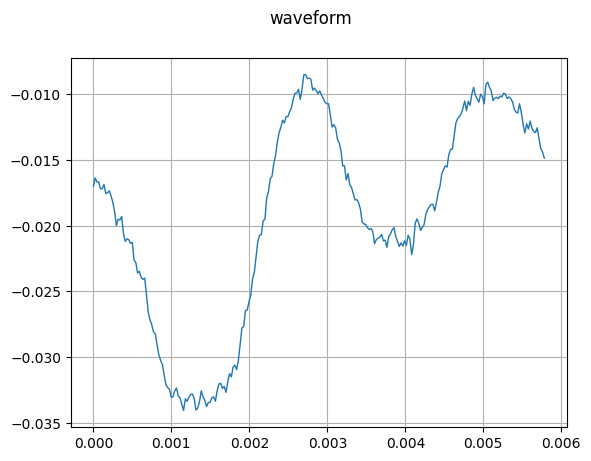

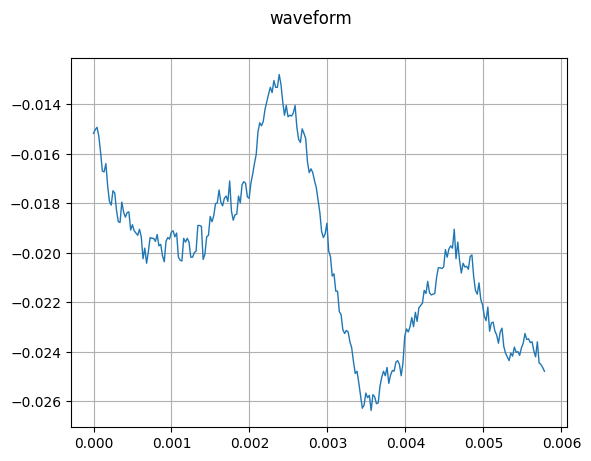

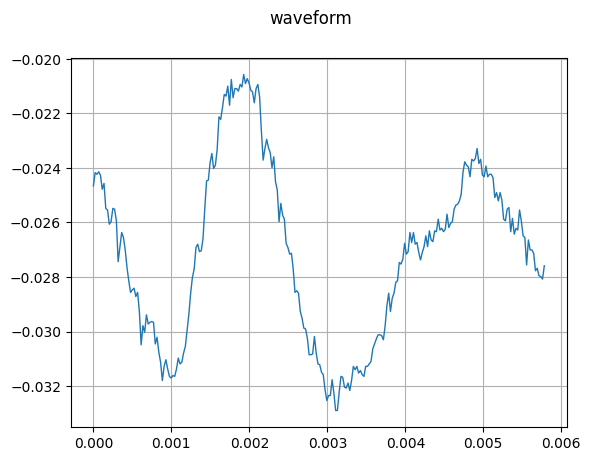

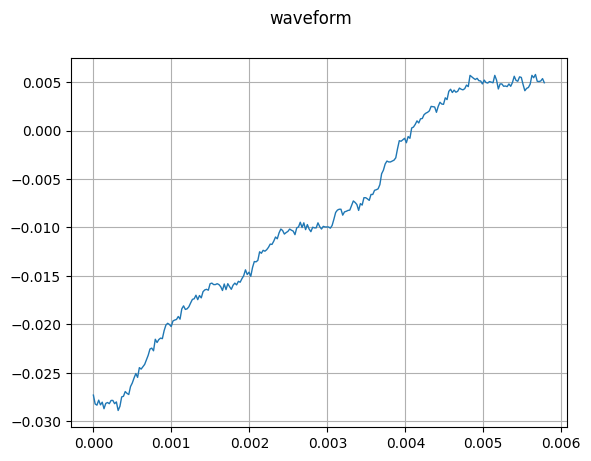


KeyboardInterrupt



In [36]:
"""
Nothing to touch after this!
"""
init()
# simulate block based processing
signal_proc = np.zeros(n_buffers*buffer_len, dtype=data_type)
for k in range(n_buffers):

    # index the appropriate samples
    input_buffer = waveform[0,k*buffer_len:(k+1)*buffer_len]
    process(input_buffer, output_buffer, buffer_len)
    signal_proc[k*buffer_len:(k+1)*buffer_len] = output_buffer
    plot_waveform(torch.tensor(input_buffer).view(1,-1), sr)

# write to WAV
#wavfile.write("speech_mod.wav", samp_freq, signal_proc)

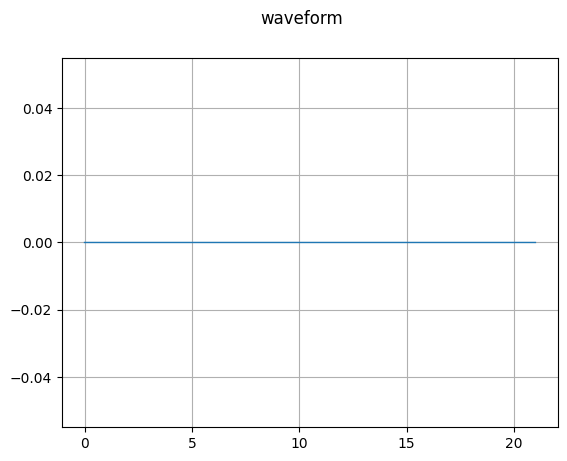

In [33]:
plot_waveform(torch.tensor(signal_proc).view(1, -1), sr)

## 데이터 중 label 없는건 지우기

In [16]:
train_label = glob.glob('data/train_data(old)/label-*')

In [22]:
for _, path in enumerate(train_label):
    labels = np.load(path)
    if sum(sum(labels))>0:
        shutil.move(path, 'data/train_data')
        shutil.move(path.replace('label', 'ex'), 'data/train_data')

# 레이블 불러오기 및 개별로 찢기(이건 나중엔 필요 없어질것)

In [5]:
label = pd.read_csv('data/label_list.csv')

In [44]:
label

,filename,class,start,end,aug
0,0001-1,wheezing,3.929,4.187,0
1,0001-3,wheezing,2.767,3.118,0
2,0001-4,wheezing,0.085,0.233,0
3,0001-4,wheezing,0.738,1.102,0
4,0020-1,wheezing,2.700,3.240,0
...,...,...,...,...,...
184,0614-4,wheezing,12.398,12.755,0
185,0615-1,wheezing,2.701,3.370,0
186,0615-1,wheezing,6.024,6.369,0
187,0615-1,wheezing,9.104,9.344,0


In [4]:
audio_files = glob.glob('data/seg_wav/*.wav')

In [5]:
data = np.array(label)
data

array([['0001-1', 'wheezing', 3.929, 4.187, 0],
       ['0001-3', 'wheezing', 2.767, 3.118, 0],
       ['0001-4', 'wheezing', 0.085, 0.233, 0],
       ['0001-4', 'wheezing', 0.738, 1.102, 0],
       ['0020-1', 'wheezing', 2.7, 3.24, 0],
       ['0020-3', 'wheezing', 0.0, 0.262, 0],
       ['0020-3', 'wheezing', 2.215, 2.658, 0],
       ['0020-3', 'wheezing', 5.018, 5.436, 0],
       ['0020-4', 'wheezing', 2.258, 2.647, 0],
       ['0025-3', 'wheezing', 0.0, 0.49, 0],
       ['0025-3', 'wheezing', 5.271, 5.521, 0],
       ['0025-3', 'wheezing', 6.375, 6.637, 0],
       ['0025-4', 'wheezing', 0.55, 0.755, 0],
       ['0025-4', 'wheezing', 1.206, 1.414, 0],
       ['0107-1', 'wheezing', 5.025, 5.873, 0],
       ['0107-1', 'wheezing', 7.584, 8.235, 0],
       ['0107-2', 'wheezing', 0.083, 0.626, 0],
       ['0107-2', 'wheezing', 1.11, 1.229, 0],
       ['0107-2', 'wheezing', 1.996, 2.661, 0],
       ['0107-3', 'wheezing', 0.079, 0.851, 0],
       ['0107-3', 'wheezing', 1.658, 2.068, 0],
  

In [59]:
length = 0
for _, item in enumerate(audio_files):
    audio, sr = torchaudio.load(item)
    length += len(audio[0])/sr

In [58]:
len(audio[0])/sr

3.447981859410431

In [60]:
length

690.6847906746034

In [52]:
length

0.0015490362811791402

In [47]:
sum = 0
for _, item in enumerate(data):
    sum += item[3] - item[2]

In [48]:
sum

76.11300000000003

## 1채널로 만들기

In [6]:
# 1채널 파일 경로 만들기
os.makedirs(os.path.dirname(audio_files[0]).replace('seg_wav','mono_wav'))

FileExistsError: [Errno 17] File exists: 'data/mono_wav'

In [7]:
for sound in audio_files:
    temp_file = sound.replace("seg_wav","mono_wav")
    command = "sox " + sound + " " + temp_file + " channels 1"
    p = Popen(command, stdin=PIPE, stdout=PIPE, stderr=PIPE, shell=True)
    output, err = p.communicate()

In [8]:
audio_files_mono = glob.glob('data/mono_wav/*.wav')

In [7]:
len(audio_files_mono)

74

## label 각 데이터 이름으로 재저장하기

In [28]:
now = data[0][0]
lists = []
count = 0
for i in range(len(data)):
    if now == data[i][0]:
        lists.append(data[i])
    elif count != 0 : 
        label_name=f'data/mono_wav/{data[i-1][0]}.ann'
        with open(label_name, 'w') as fp:
            fp.write('\n'.join('{},{},{}'.format(x[2], x[3], x[1]) for x in lists))
        lists = []
        now=data[i][0]
        lists.append(data[i])
    else :
        now=data[i][0]
        lists.append(data[i])
    count += 1
label_name=f'data/mono_wav/{data[i][0]}.ann'
with open(label_name, 'w') as fp:
    fp.write('\n'.join('{},{},{}'.format(x[2], x[3], x[1]) for x in lists))

# 데이터전처리

In [4]:
class_dict ={'car':0}

In [5]:
def read_annotation(filename):
    events = []
    with open(filename, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in spamreader:
            row[0]=float(row[0])
            row[1]=float(row[1])
            events.append(row)
    return events

In [6]:
def construct_example(audio_path, win_len = 2.56, hop_len = 1.0, sr = 44100):
    #1초당 윈도우, hop크기
    win_len_t = win_len
    hop_len_t = hop_len
    
    #샘플레이트에 따른 실제 윈도우, hop크기
    win_len = int(sr*win_len)
    hop_len = int(sr*hop_len)

    audio, orig_sr = sf.read(audio_path)
    audio = librosa.resample(audio, orig_sr=sr, target_sr=44100)
    
    #input에 맞도록 제로패딩하기
    if audio.shape[0] < win_len:
        audio_padded = np.zeros((win_len, ))
        audio_padded[0:audio.shape[0]] = audio
    else:
        #math.ceil은 올림을 의미. 5면 5, 5.00001이라도 있으면 6이 된다.
        #아래의 no of hops는 오디오 중 창크기보다 큰 길이만큼은 중첩을 안시키겠다는 의미
        no_of_hops = math.ceil((audio.shape[0] - win_len) / hop_len)
        audio_padded = np.zeros((int(win_len + hop_len*no_of_hops), ))
        audio_padded[0:audio.shape[0]] = audio
        
    #창에 맞도록 오디오와 윈도우 크기를 지정(교수님 말씀하셨던 대로 슬라이딩 형태다. 0~5.12초, 1~6.12초 이런 식)
    audio_ex = [audio_padded[i - win_len : i] for i in range(win_len, audio_padded.shape[0] + 1, hop_len)]
    win_ranges = [((i - win_len)/sr, i/sr) for i in range(win_len, audio_padded.shape[0] + 1, hop_len)]

    return audio_ex, win_ranges

In [7]:
def construct_labels(data, win_start, win_end, win_len):
    anno = read_annotation(data)
    curr_ann = []
    
    for a in anno:
        # 끝점이 창보다 길거나 시작점이 창의 끝보다 작을경우, 즉 창이 겹쳐야할때
        if a[1] > win_start and a[0] <= win_end:
            curr_start = max(a[0] - win_start, 0.0)
            curr_end = min(a[1] - win_start, win_len)
            curr_ann.append([curr_start, curr_end, a[2]])
    
    # 현재 데이터 레이블 중 클래스 리스트화
    class_set = set([c[2] for c in curr_ann])
    class_wise_events = {}
    
    for c in list(class_set):
        class_wise_events[c] = []

    for c in curr_ann:
        class_wise_events[c[2]].append(c)
    
    max_event_silence = 0.0
    all_events = []
    
    for k in list(class_wise_events.keys()):
        curr_events = class_wise_events[k]
        count = 0
    
        while count < len(curr_events) - 1:
            if (curr_events[count][1] >= curr_events[count + 1][0]) or (curr_events[count + 1][0] - curr_events[count][1] <= max_event_silence):
                curr_events[count][1] = max(curr_events[count + 1][1], curr_events[count][1])
                del curr_events[count + 1]
            else:
                count += 1
        all_events += curr_events
    
    for i in range(len(all_events)):
        all_events[i][0] = round(all_events[i][0], 3)
        all_events[i][1] = round(all_events[i][1], 3)
    
    all_events.sort(key=lambda x: x[0])
    
    return all_events

In [8]:
def get_universal_labels(events, class_dict, ex_length = 10.0, no_of_div = 32):
    win_length = ex_length/no_of_div
    labels = np.zeros((no_of_div, len(class_dict.keys()) * 3))
    
    for e in events:

        start_time = float(e[0])
        stop_time = float(e[1])
    
        start_bin = int(start_time // win_length)
        stop_bin = int(stop_time // win_length)
    
        start_time_2 = start_time - start_bin * win_length
        stop_time_2 = stop_time - stop_bin * win_length
    
        n_bins = stop_bin - start_bin
    
        #아래가 원래는 여러 클래스별로 위치를 지정해줬었는데, 우리는 단일이니 제거함.
        if n_bins == 0:
            labels[start_bin] = [1, start_time_2, stop_time_2]    
        
        elif n_bins == 1:
            labels[start_bin] = [1, start_time_2, win_length]
            
            if stop_time_2 > 0.0:
                labels[stop_bin] = [1, 0.0, stop_time_2]
            
        elif n_bins > 1:
            labels[start_bin] = [1, start_time_2, win_length]
        
            for i in range(1, n_bins):
                labels[start_bin + i] = [1, 0.0, win_length]
            
            if stop_time_2 > 0.0:
                labels[stop_bin] = [1, 0.0, stop_time_2]
    
      # labels[:, [1, 2, 4, 5]] /= win_length

    for i in range(len(labels)):
        for j in range(len(labels[i])):
            if j % 3 != 0:
                labels[i][j] /= win_length
    
    return labels

## train/val 나누기

In [14]:
file_names = glob.glob('data/mono_wav/*.wav')
random.shuffle(file_names)

In [15]:
train_data = file_names[:int(len(file_names)*0.9)]
val_data = file_names[int(len(file_names)*0.9):]

In [40]:
os.mkdir('data/train_data')
os.mkdir('data/val_data')

FileExistsError: [Errno 17] File exists: 'data/train_data'

In [42]:
for name in train_data:
    print(name)
    shutil.move(name, name.replace("mono_wav","train_data"))
    shutil.move(name.replace(".wav",".ann"), name.replace("mono_wav","train_data").replace(".wav",".ann"))

data/mono_wav/0611-2.wav
data/mono_wav/0411-2.wav
data/mono_wav/0261-3.wav
data/mono_wav/0538-1.wav
data/mono_wav/0597-2.wav
data/mono_wav/0538-4.wav
data/mono_wav/0593-3.wav
data/mono_wav/0559-1.wav
data/mono_wav/0600-2.wav
data/mono_wav/0559-2.wav
data/mono_wav/0581-1.wav
data/mono_wav/0526-4.wav
data/mono_wav/0001-3.wav
data/mono_wav/0020-4.wav
data/mono_wav/0613-2.wav
data/mono_wav/0559-3.wav
data/mono_wav/0526-3.wav
data/mono_wav/0615-1.wav
data/mono_wav/0593-4.wav
data/mono_wav/0534-4.wav
data/mono_wav/0411-3.wav
data/mono_wav/0614-3.wav
data/mono_wav/0559-4.wav
data/mono_wav/0538-3.wav
data/mono_wav/0107-4.wav
data/mono_wav/0613-3.wav
data/mono_wav/0020-1.wav
data/mono_wav/0590-3.wav
data/mono_wav/0588-3.wav
data/mono_wav/0515-1.wav
data/mono_wav/0107-3.wav
data/mono_wav/0604-1.wav
data/mono_wav/0590-2.wav
data/mono_wav/0612-1.wav
data/mono_wav/0614-4.wav
data/mono_wav/0538-2.wav
data/mono_wav/0607-3.wav
data/mono_wav/0594-1.wav
data/mono_wav/0568-2.wav
data/mono_wav/0600-1.wav


In [41]:
for name in val_data:
    print(name)
    shutil.move(name, name.replace("mono_wav","val_data"))
    shutil.move(name.replace(".wav",".ann"), name.replace("mono_wav","val_data").replace(".wav",".ann"))

data/mono_wav/0581-4.wav
data/mono_wav/0603-1.wav
data/mono_wav/0602-3.wav
data/mono_wav/0001-1.wav
data/mono_wav/0611-1.wav
data/mono_wav/0568-4.wav
data/mono_wav/0535-3.wav
data/mono_wav/0550-3.wav


## 함수를 적용한 오디오별 레이블, 데이터셋 처럼 레이블 만들기

In [8]:
train_data = glob.glob('data/train_data/*.wav')
val_data = glob.glob('data/val_data/*.wav')

In [95]:
win_len = 2.56
hop_len = 1.96
a_ex_train = []
a_labels_train = []

for i, audio in enumerate(train_data):
    a, win_ranges = construct_example(audio, win_len=win_len, hop_len=hop_len)
    a_ex_train += a
    
    for w in win_ranges:
        labels_t = construct_labels(audio.replace(".wav", ".ann"), w[0], w[1], win_len=win_len)
        ll = get_universal_labels(labels_t, class_dict, ex_length=win_len, no_of_div = 9)
        a_labels_train.append(ll)
        


## 조각낸 오디오, 레이블 파일 melspec화하기

In [9]:
def get_log_melspectrogram(audio, sr = 44100, hop_length = 441, win_length = 1764, n_fft = 2048, n_mels = 40, fmin = 0, fmax = 22050):
    """Return the log-scaled Mel bands of an audio signal."""
    audio_2 = librosa.util.normalize(audio)
    bands = librosa.feature.melspectrogram(
        y=audio_2, sr=sr, hop_length=hop_length, win_length = win_length, n_fft=n_fft, n_mels=n_mels)
    return librosa.core.power_to_db(bands)

In [10]:
plt.figure()
librosa.display.specshow(M_origin)
plt.colorbar()
M_origin.shape

NameError: name 'M_origin' is not defined

<Figure size 640x480 with 0 Axes>

In [19]:
# a, sr = sf.read(audio_files_mono[0])
M_origin = get_log_melspectrogram(training_generator[0][0][0,:,:,0])

ParameterError: Invalid shape for monophonic audio: ndim=2, shape=(257, 40)

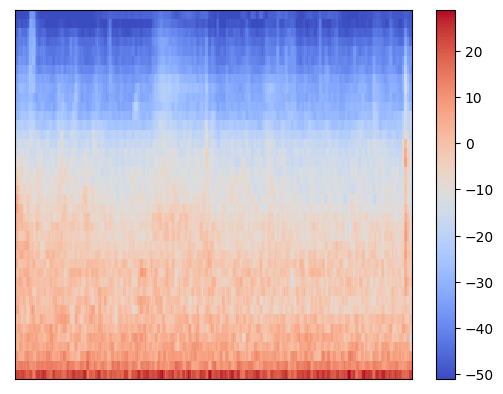

In [27]:
plt.figure()
librosa.display.specshow(np.array(training_generator[0][0][0,:,:,0]).T)
plt.colorbar()

In [85]:
# a, sr = sf.read(audio_files_mono[0])
M_80_1024 = get_log_melspectrogram(a_ex_train[0], n_mels=257, win_length=1024, n_fft=4096)

IndexError: list index out of range

In [338]:
M_80_1024.shape

(257, 257)

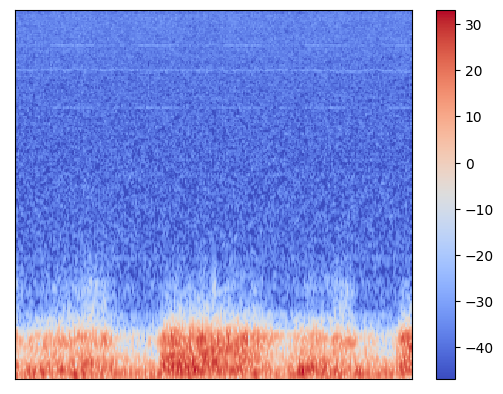

In [339]:
plt.figure()
librosa.display.specshow(M_80_1024)
plt.colorbar()

In [81]:
a_labels_train[7]

IndexError: list index out of range

In [97]:
for i, a in enumerate(a_ex_train):
    M = get_log_melspectrogram(a).T
    np.save('data/train_data/ex-'+str(i)+'.npy', M)

In [98]:
for i, a in enumerate(a_labels_train):
  np.save("data/train_data/label-" + str(i) + ".npy", a)

In [102]:
np.load('data/train_data/label-2.npy')

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [1.        , 0.1640625 , 1.        ],
       [1.        , 0.        , 1.        ],
       [1.        , 0.        , 1.        ],
       [1.        , 0.        , 0.54257813],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

##### np.load('you-only-hear-once/content/train-data/label-0.npy')

In [25]:
"""
Construct val set
"""

win_len = 2.56
hop_len = 1.96
a_ex_val = []
a_labels_val = []

# win_size = 10.0
# win_start = 16.0
# win_end = win_start + win_size

for i, audio in enumerate(val_data):
  a, win_ranges = construct_example(audio, win_len=win_len, hop_len=hop_len)
  a_ex_val += a

  for w in win_ranges:
    labels_t = construct_labels(audio.replace(".wav", ".ann"), w[0], w[1], win_len=win_len)
    ll = get_universal_labels(labels_t, class_dict, ex_length=win_len, no_of_div = 9)
    a_labels_val.append(ll)

In [100]:
for i, a in enumerate(a_ex_val):
  M = get_log_melspectrogram(a).T
  np.save("data/val_data/ex-" + str(i) + ".npy", M)

In [101]:
for i, a in enumerate(a_labels_val):
  np.save("data/val_data/label-" + str(i) + ".npy", a)

# dataset(제네레이터)생성

In [10]:
def tryint(s):
    try:
        return int(s)
    except ValueError:
        return s
    
def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)

In [11]:
"""
Load the individual numpy arrays into partition
"""
#train_data = glob.glob("data/train_data/ex-*.npy")
train_data = glob.glob("yoho/content/train-data/ex-*.npy")
sort_nicely(train_data)

#train_labels = glob.glob("data/train_data/label-*.npy")
train_labels = glob.glob("yoho/content/train-data/label-*.npy")
sort_nicely(train_labels)

train_examples = [(train_data[i], train_labels[i]) for i in range(len(train_data))]

random.seed(4)
random.shuffle(train_examples)

In [12]:
"""
Creating the train partition.
"""
partition = {}
partition['train'] = train_examples

random.shuffle(partition['train'])

In [13]:
#val_data = glob.glob("data/val_data/ex-*.npy")
val_data = glob.glob("yoho/content/val-data/ex-*.npy")
sort_nicely(val_data)

val_labels = glob.glob("yoho/content/val-data/label-*.npy")
sort_nicely(val_labels)

val_examples = [(val_data[i], val_labels[i]) for i in range(len(val_data))]

random.seed(4)
random.shuffle(val_examples)

In [14]:
partition['validation'] = val_examples

In [25]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_examples, batch_size=32, epoch_size = 100, dim=(1, ),
                 n_classes=1, shuffle=True):
        'Initialization'
        print("Constructor called!!!")
        self.dim = dim
        self.batch_size = batch_size
        self.epoch_size = epoch_size
        self.list_examples = list_examples
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        #print("The self.list_examples is {}".format(self.list_examples))
        return int(np.floor(len(self.list_examples) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_examples[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y
        
    def on_epoch_end(self):
      self.indexes = np.arange(len(self.list_examples))
      if self.shuffle == True:
          np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # 'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # # Initialization
        X = np.empty([self.batch_size, 257, 40, 1], dtype=np.float64)
        y = np.empty([self.batch_size, 9, 18], dtype=np.float64)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
          # Store sample

          xx = np.load(ID[0])

          X[i, :, :, 0] = xx

          # Store class
          yy = np.load(ID[1])
          y[i, :, :] = yy

        tau = X.shape[1]          
        v = X.shape[2]

        #warped_frequency_spectrogram = spec_augment_tensorflow.frequency_masking(X, v=v,  frequency_masking_para=8, frequency_mask_num=1)
        #warped_frequency_time_sepctrogram = spec_augment_tensorflow.time_masking(warped_frequency_spectrogram, tau=tau, time_masking_para=25, time_mask_num=2)

        #X = warped_frequency_time_sepctrogram

        #원 모델 test
        y = y[:,:,:3]

        return X, y

In [26]:
# Generators
training_generator = DataGenerator(partition['train'], **generator_params)
validation_generator = DataGenerator(partition['validation'], **generator_params)

Constructor called!!!
Constructor called!!!


In [24]:
training_generator[0][1]

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.       

# network 구축

In [42]:
# Creates mel spctrograms for training
#test_data = glob.glob('data/val_data/*.wav')
test_data = glob.glob('yoho/content/eval-files-2/*.wav')

win_length = 2.56
hop_size = 1.96
mss_ins = []
win_ranges_list = []


for ii, audio in enumerate(test_data):
  a, win_ranges = construct_example(audio, win_len=win_length,hop_len=hop_size)

  mss_in = np.zeros((len(a), 257, 40))

  preds = np.zeros((len(a), 9, 3))


  for i in range(len(a)):
    M = get_log_melspectrogram(a[i])
    mss_in[i, :, :] = M.T
  mss_ins.append(mss_in)
  win_ranges_list.append(win_ranges)

In [48]:
mss_ins

[]

In [45]:
model.predict(mss_ins)

KeyError: 'pop from an empty set'

In [30]:
def mk_preds_YOHO_mel(model, ind, mss_ins=mss_ins, no_of_div = 9, hop_size = 1.96, discard = 0.3, win_length = 2.56, max_event_silence = 0.3, sampling_rate = 44100):
    preds = model.predict(mss_ins[ind], verbose=0)
    events = []
    
    for i in range(len(preds)):
        p = preds[i, :, :]
        events_curr = []
        win_width = win_length / no_of_div
        for j in range(len(p)):
            #원본은 0~6번 레이블별로 jjj*3이었으나 우리는 1개이니 0
            #아래는 이 오디오에 대한 예측값이 0.5 이상이면 현재 이벤트가 존재한다고 예측하라는 의미
            if p[j][0] >= 0.5:
                start = win_width * j + win_width * p[j][1] + win_ranges_list[ind][i][0]
                end = p[j][2] * win_width + start
                events_curr.append([start, end, rev_class_dict[0]])
    
        events += events_curr
    
    class_set = set([c[2] for c in events])
    class_wise_events = {}
    
    for c in list(class_set):
        class_wise_events[c] = []
    
    
    for c in events:
        class_wise_events[c[2]].append(c)
    
    all_events = []
    
    for k in list(class_wise_events.keys()):
        curr_events = class_wise_events[k]
        count = 0
        
        while count < len(curr_events) - 1:
            if (curr_events[count][1] >= curr_events[count + 1][0]) or (curr_events[count + 1][0] - curr_events[count][1] <= max_event_silence):
                curr_events[count][1] = max(curr_events[count + 1][1], curr_events[count][1])
                del curr_events[count + 1]
            else:
                count += 1
    
        all_events += curr_events
    
    for i in range(len(all_events)):
        all_events[i][0] = round(all_events[i][0], 3)
        all_events[i][1] = round(all_events[i][1], 3)
    
    all_events.sort(key=lambda x: x[0])

    return all_events


In [31]:
rev_class_dict = ['car']

In [32]:
def frames_to_time(f, sr = 44100.0, hop_size = 441):
  return f * hop_size / sr

def preds_to_se(p, win_start, audio_clip_length = 2.56):
  start_dicts = [-100, -100, -100, -100, -100, -100]
  stop_dicts = [-100, -100, -100, -100, -100, -100]


  start_speech = -100
  start_music = -100
  stop_speech = -100
  stop_music = -100

  audio_events = []

  n_frames = p.shape[0]

  for j in range(p.shape[1]):
    if p[0, j] >= 0.5:
      start_dicts[j] = 0

  for j in range(p.shape[1]):
    for i in range(n_frames - 1):
      if p[i, j] < 0.5 and p[i+1, j] >= 0.5:
        start_dicts[j] = i+1

      elif p[i, j] >= 0.5 and p[i + 1, j] < 0.5:
        stop_dicts[j] = i
        start_time = frames_to_time(start_dicts[j])
        stop_time = frames_to_time(stop_dicts[j])

        audio_events.append([start_time+win_start, stop_time+win_start, rev_class_dict[j]])
        start_dicts[j] = -100
        stop_dicts[j] = -100

    if start_dicts[j] != -100:
      start_time = frames_to_time(start_dicts[j])
      stop_time = audio_clip_length
      audio_events.append([start_time+win_start, stop_time+win_start, rev_class_dict[j]])
      start_dicts[j] = -100
      stop_dicts[j] = -100

  audio_events.sort(key = lambda x: x[0]) 
  return audio_events

In [33]:
class MyCustomCallback_44(tf.keras.callbacks.Callback):
    def __init__(self):
        super(MyCustomCallback_44, self).__init__()
        self.best_f1 = 0.0
        self.best_error = np.inf

    
    def on_train_begin(self, logs=None):
        pass

    def on_train_end(self, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        if epoch > 1:
            for ii, audio in enumerate(test_data):
                audio_file_path = audio
                see = mk_preds_YOHO_mel(model, ii, mss_ins=mss_ins)
                #n_label = n_label = "data/val_data/" + os.path.basename(audio_file_path).replace(".wav" ,"") + "-se-prediction.ann"
                n_label = n_label = "yoho/content/eval-files-2/" + os.path.basename(audio_file_path).replace(".wav" ,"") + "-se-prediction.ann"
                
                with open(n_label, 'w') as fp:
                    fp.write('\n'.join('{},{},{}'.format(x[0], x[1], x[2]) for x in see))
                
            #destination = "data/val_data/"
            destination = "yoho/content/eval-files-2/"
            test_set = glob.glob(destination + "*[0-9].ann")
            
            file_list = [
                {
                    'reference_file': tt,
                    'estimated_file': tt.replace(".ann","-se-prediction.ann")
                }
                for tt in test_set
            ]
            
            data = []
            
            # Get used event labels
            all_data = dcase_util.containers.MetaDataContainer()
            for file_pair in file_list:
                reference_event_list = sed_eval.io.load_event_list(
                    filename=file_pair['reference_file']
                )
                estimated_event_list = sed_eval.io.load_event_list(
                    filename=file_pair['estimated_file']
                )
                
                data.append({'reference_event_list': reference_event_list,
                             'estimated_event_list': estimated_event_list})
                
                all_data += reference_event_list
            
            event_labels = all_data.unique_event_labels
            
            # Start evaluating
            
            # Create metrics classes, define parameters
            segment_based_metrics = sed_eval.sound_event.SegmentBasedMetrics(
                event_label_list=event_labels,
                time_resolution=1.0
            )
            
            event_based_metrics = sed_eval.sound_event.EventBasedMetrics(
                event_label_list=event_labels,
                t_collar=1.0
            )
            
            # Go through files
            for file_pair in data:
                segment_based_metrics.evaluate(
                    reference_event_list=file_pair['reference_event_list'],
                    estimated_event_list=file_pair['estimated_event_list']
                )
                
                event_based_metrics.evaluate(
                    reference_event_list=file_pair['reference_event_list'],
                    estimated_event_list=file_pair['estimated_event_list']
                )
            
            # Get only certain metrics
            overall_segment_based_metrics = segment_based_metrics.results_overall_metrics()
            curr_f1 = overall_segment_based_metrics['f_measure']['f_measure']
            curr_error = overall_segment_based_metrics['error_rate']['error_rate']
            
            if not os.path.exists('./results'):
                os.mkdir('./results')
            if curr_f1 > self.best_f1:
                self.best_f1 = curr_f1
                self.model.save_weights("./results/model-best-f1.h5")
            
            if curr_error < self.best_error:
                self.best_error = curr_error
                self.model.save_weights("./results/model-best-error.h5")
            
            print("F-measure: {:.3f} vs {:.3f}".format(curr_f1, self.best_f1))
            print("Error rate: {:.3f} vs {:.3f}".format(curr_error, self.best_error))

### def mk_pred_YOHO

In [48]:
audio_path = audio
no_of_div = 9
hop_size = 1.96
discard = 0.3
win_length = 2.56
max_event_silence = 0.3
sampling_rate = 44100

In [101]:
a, win_ranges = construct_example(audio_path, win_len=win_length,hop_len=hop_size)

preds = np.zeros((len(a), 9, 18))
mss_in = np.zeros((len(a), 257, 40))

for i in range(len(a)):
    M = get_log_melspectrogram(a[i])
    mss_in[i, :, :] = M.T

preds = model.predict(mss_in)
events = []

for i in range(len(preds)):
    p = preds[i, :, :]
    events_curr = []
    win_width = win_length / no_of_div
    for j in range(len(p)):
        #원본은 0~6번 레이블별로 jjj*3이었으나 우리는 1개이니 0
        #아래는 이 오디오에 대한 예측값이 0.5 이상이면 현재 이벤트가 존재한다고 예측하라는 의미
        if p[j][0] >= 0.3:
            start = win_width * j + win_width * p[j][1] + win_ranges[i][0]
            end = p[j][2] * win_width + start
            events_curr.append([start, end, rev_class_dict[0]])

    events += events_curr

class_set = set([c[2] for c in events])
class_wise_events = {}

for c in list(class_set):
    class_wise_events[c] = []


for c in events:
    class_wise_events[c[2]].append(c)

all_events = []

for k in list(class_wise_events.keys()):
    curr_events = class_wise_events[k]
    count = 0
    
    while count < len(curr_events) - 1:
        if (curr_events[count][1] >= curr_events[count + 1][0]) or (curr_events[count + 1][0] - curr_events[count][1] <= max_event_silence):
            curr_events[count][1] = max(curr_events[count + 1][1], curr_events[count][1])
            del curr_events[count + 1]
        else:
            count += 1

    all_events += curr_events

for i in range(len(all_events)):
    all_events[i][0] = round(all_events[i][0], 3)
    all_events[i][1] = round(all_events[i][1], 3)

all_events.sort(key=lambda x: x[0])

1/1 [==============================] - 0s 40ms/step


In [67]:
all_events

[[0.153, 4.527, 'wheezing']]

### MyCustomCallback_44 test

In [73]:
for ii, audio in enumerate(val_data):
    audio_file_path = audio
    see = mk_preds_YOHO_mel(model, audio)
    n_label = n_label = "data/val_audio/" + os.path.basename(audio_file_path).replace(".wav" ,"") + "-se-prediction.ann"
    
    with open(n_label, 'w') as fp:
        fp.write('\n'.join('{},{},{}'.format(x[0], x[1], x[2]) for x in see))
    
destination = "data/val_audio/"
test_set = glob.glob(destination + "*[0-9].ann")

file_list = [
    {
        'reference_file': tt,
        'estimated_file': tt.replace(".ann","-se-prediction.ann")
    }
    for tt in test_set
]

data = []

# Get used event labels
all_data = dcase_util.containers.MetaDataContainer()
for file_pair in file_list:
    reference_event_list = sed_eval.io.load_event_list(
        filename=file_pair['reference_file']
    )
    estimated_event_list = sed_eval.io.load_event_list(
        filename=file_pair['estimated_file']
    )
    
    data.append({'reference_event_list': reference_event_list,
                 'estimated_event_list': estimated_event_list})
    
    all_data += reference_event_list

event_labels = all_data.unique_event_labels

# Start evaluating

# Create metrics classes, define parameters
segment_based_metrics = sed_eval.sound_event.SegmentBasedMetrics(
    event_label_list=event_labels,
    time_resolution=1.0
)

event_based_metrics = sed_eval.sound_event.EventBasedMetrics(
    event_label_list=event_labels,
    t_collar=1.0
)

# Go through files
for file_pair in data:
    segment_based_metrics.evaluate(
        reference_event_list=file_pair['reference_event_list'],
        estimated_event_list=file_pair['estimated_event_list']
    )
    
    event_based_metrics.evaluate(
        reference_event_list=file_pair['reference_event_list'],
        estimated_event_list=file_pair['estimated_event_list']
    )

# Get only certain metrics
overall_segment_based_metrics = segment_based_metrics.results_overall_metrics()
curr_f1 = overall_segment_based_metrics['f_measure']['f_measure']
curr_error = overall_segment_based_metrics['error_rate']['error_rate']

if curr_f1 > self.best_f1:
    self.best_f1 = curr_f1
    self.model.save_weights("/content/model-best-f1.h5")

if curr_error < self.best_error:
    self.best_error = curr_error
    self.model.save_weights("/content/model-best-error.h5")

print("F-measure: {:.3f} vs {:.3f}".format(curr_f1, curr_f1))
print("Error rate: {:.3f} vs {:.3f}".format(curr_error, curr_error))

1/1 [==============================] - 0s 46ms/step


In [76]:
file_list

[{'reference_file': 'data/val_audio/0107-2.ann',
  'estimated_file': 'data/val_audio/0107-2-se-prediction.ann'},
 {'reference_file': 'data/val_audio/0020-1.ann',
  'estimated_file': 'data/val_audio/0020-1-se-prediction.ann'},
 {'reference_file': 'data/val_audio/0615-1.ann',
  'estimated_file': 'data/val_audio/0615-1-se-prediction.ann'},
 {'reference_file': 'data/val_audio/0534-4.ann',
  'estimated_file': 'data/val_audio/0534-4-se-prediction.ann'},
 {'reference_file': 'data/val_audio/0411-2.ann',
  'estimated_file': 'data/val_audio/0411-2-se-prediction.ann'},
 {'reference_file': 'data/val_audio/0568-2.ann',
  'estimated_file': 'data/val_audio/0568-2-se-prediction.ann'},
 {'reference_file': 'data/val_audio/0602-3.ann',
  'estimated_file': 'data/val_audio/0602-3-se-prediction.ann'},
 {'reference_file': 'data/val_audio/0001-3.ann',
  'estimated_file': 'data/val_audio/0001-3-se-prediction.ann'}]

In [82]:
file_pair['reference_file']

'data/val_audio/0615-1.ann'

In [83]:
sed_eval.io.load_event_list(file_pair['reference_file'])

[{'onset': 4.585, 'offset': 5.095, 'event_label': 'wheezing'},
 {'onset': 12.398, 'offset': 12.755, 'event_label': 'wheezing'}]

F-measure: 0.462 vs 0.462
Error rate: 1.581 vs 1.581


## 모델 및 Loss 함수 정의

In [34]:
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)

    ss_True = squared_difference[:, :, 0] * 0 + 1
    ss = y_true[:, :, 0]

    sss = tf.stack((ss_True, ss, ss), axis=2)
    
    squared_differences = tf.multiply(squared_difference, sss)

    #return squared_difference
    return tf.reduce_sum(squared_differences, axis=[-1, -2])

In [35]:
LAYER_DEFS = [
    # (layer_function, kernel, stride, num_filters)
    ([3, 3], 1,   64),
    ([3, 3], 2,  128),
    ([3, 3], 1,  128),
    ([3, 3], 2,  256),
    ([3, 3], 1,  256),
    ([3, 3], 2,  512),
    ([3, 3], 1,  512),
    ([3, 3], 1,  512),
    ([3, 3], 1,  512),
    ([3, 3], 1,  512),
    ([3, 3], 1,  512),
    ([3, 3], 2, 1024),
    ([3, 3], 1, 1024),
    ([3, 3], 1, 512),
    ([3, 3], 1, 256),
    ([3, 3], 1, 128),
    # ([3, 3], 1, 128),
    # ([3, 3], 1, 128)
]

In [85]:
my_loss_fn(model.predict(t1[0]),t1[1][0])

1/1 [==============================] - 0s 98ms/step


<tf.Tensor: shape=(32,), dtype=float64, numpy=
array([3.85341602, 3.85341602, 3.85341602, 3.85341602, 3.85341602,
       3.85341602, 3.85341602, 3.85341602, 3.85341598, 3.85341602,
       3.85341602, 3.85341602, 3.85341602, 3.85341602, 3.85341602,
       3.85341602, 3.85341602, 3.85341602, 3.85341598, 3.85341602,
       3.85341602, 3.85341602, 3.85341602, 3.85341602, 3.85341602,
       3.85341602, 3.85341602, 3.85341602, 3.85341606, 3.85341602,
       3.85341602, 3.85341602])>

In [36]:
m_features = tf.keras.Input(shape=(257, 40), name="mel_input")
X = m_features
X = tf.keras.layers.Reshape((257, 40, 1))(X)
X = tf.keras.layers.Conv2D(filters = 32, kernel_size=[3, 3], strides=2, padding='same', use_bias=False,
                           activation=None, name = "layer1/conv",
                             kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(X)
X = tf.keras.layers.BatchNormalization(center=True, scale=False, epsilon=1e-4, name = "layer1/bn")(X)
X = tf.keras.layers.ReLU(name="layer1/relu")(X)

X = tf.keras.layers.DepthwiseConv2D(kernel_size=[3,3], strides = 2, depth_multiplier=1, padding='same', use_bias=False,
                                  activation=None, name="layer"+ str(0 + 2)+"/depthwise_conv")(X)
X = tf.keras.layers.BatchNormalization(center=True, scale=False, epsilon=1e-4, name = "layer"+ str(0 + 2)+"/depthwise_conv/bn")(X)
X = tf.keras.layers.ReLU(name="layer"+ str(0 + 2)+"/depthwise_conv/relu")(X)
X = tf.keras.layers.Conv2D(filters = 64, kernel_size=[1, 1], strides=2, padding='same', use_bias=False, activation=None,
                         name = "layer"+ str(0 + 2)+"/pointwise_conv",
                         kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(X)
X = tf.keras.layers.BatchNormalization(center=True, scale=False, epsilon=1e-4, name = "layer"+ str(0 + 2)+"/pointwise_conv/bn")(X)
X = tf.keras.layers.ReLU(name="layer"+ str(0 + 2)+"/pointwise_conv/relu")(X)

X = tf.keras.layers.DepthwiseConv2D(kernel_size=[3,3], strides = 2, depth_multiplier=1, padding='same', use_bias=False,
                                  activation=None, name="layer"+ str(1 + 2)+"/depthwise_conv")(X)
X = tf.keras.layers.BatchNormalization(center=True, scale=False, epsilon=1e-4, name = "layer"+ str(1 + 2)+"/depthwise_conv/bn")(X)
X = tf.keras.layers.ReLU(name="layer"+ str(1 + 2)+"/depthwise_conv/relu")(X)
X = tf.keras.layers.Conv2D(filters = 64, kernel_size=[1, 1], strides=2, padding='same', use_bias=False, activation=None,
                         name = "layer"+ str(1 + 2)+"/pointwise_conv",
                         kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(X)
X = tf.keras.layers.BatchNormalization(center=True, scale=False, epsilon=1e-4, name = "layer"+ str(1 + 2)+"/pointwise_conv/bn")(X)
X = tf.keras.layers.ReLU(name="layer"+ str(1 + 2)+"/pointwise_conv/relu")(X)

X = tf.keras.layers.SpatialDropout2D(0.1)(X)
_, _, sx, sy = X.shape
X = tf.keras.layers.Reshape((-1, int(sx * sy)))(X)
pred = tf.keras.layers.Conv1D(3,kernel_size=1, activation="sigmoid")(X)
model = tf.keras.Model(
      name='yamnet_frames', inputs=m_features,
      outputs=[pred])

In [37]:
model.summary()

Model: "yamnet_frames"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mel_input (InputLayer)      [(None, 257, 40)]         0         
                                                                 
 reshape (Reshape)           (None, 257, 40, 1)        0         
                                                                 
 layer1/conv (Conv2D)        (None, 129, 20, 32)       288       
                                                                 
 layer1/bn (BatchNormalizat  (None, 129, 20, 32)       96        
 ion)                                                            
                                                                 
 layer1/relu (ReLU)          (None, 129, 20, 32)       0         
                                                                 
 layer2/depthwise_conv (Dep  (None, 65, 10, 32)        288       
 thwiseConv2D)                                       

In [38]:
"""
Manually define YOHO network
"""

# params = yamnet_params.Params()
m_features = tf.keras.Input(shape=(257, 40), name="mel_input")
X = m_features
X = tf.keras.layers.Reshape((257, 40, 1))(X)
X = tf.keras.layers.Conv2D(filters = 32, kernel_size=[3, 3], strides=2, padding='same', use_bias=False,
                           activation=None, name = "layer1/conv",
                             kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(X)
X = tf.keras.layers.BatchNormalization(center=True, scale=False, epsilon=1e-4, name = "layer1/bn")(X)
X = tf.keras.layers.ReLU(name="layer1/relu")(X)

# X = tf.keras.layers.SpatialDropout2D(0.5)(X)

for i in range(len(LAYER_DEFS)):
  X = tf.keras.layers.DepthwiseConv2D(kernel_size=LAYER_DEFS[i][0], strides = LAYER_DEFS[i][1], depth_multiplier=1, padding='same', use_bias=False,
                                      activation=None, name="layer"+ str(i + 2)+"/depthwise_conv")(X)
  X = tf.keras.layers.BatchNormalization(center=True, scale=False, epsilon=1e-4, name = "layer"+ str(i + 2)+"/depthwise_conv/bn")(X)
  X = tf.keras.layers.ReLU(name="layer"+ str(i + 2)+"/depthwise_conv/relu")(X)
  X = tf.keras.layers.Conv2D(filters = LAYER_DEFS[i][2], kernel_size=[1, 1], strides=1, padding='same', use_bias=False, activation=None,
                             name = "layer"+ str(i + 2)+"/pointwise_conv",
                             kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(X)
  X = tf.keras.layers.BatchNormalization(center=True, scale=False, epsilon=1e-4, name = "layer"+ str(i + 2)+"/pointwise_conv/bn")(X)
  X = tf.keras.layers.ReLU(name="layer"+ str(i + 2)+"/pointwise_conv/relu")(X)

  X = tf.keras.layers.SpatialDropout2D(0.1)(X)

_, _, sx, sy = X.shape
X = tf.keras.layers.Reshape((-1, int(sx * sy)))(X)
pred = tf.keras.layers.Conv1D(3,kernel_size=1, activation="sigmoid")(X)
model = tf.keras.Model(
      name='yamnet_frames', inputs=m_features,
      outputs=[pred])

In [39]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=my_loss_fn, run_eagerly=True)

In [ ]:
model.fit(training_generator, validation_data=validation_generator, epochs=100, callbacks=[MyCustomCallback_44()], verbose=1)

Epoch 1/100
67/67 [==============================] - 42s 613ms/step - loss: 51.6863 - val_loss: 38.3950
Epoch 2/100
67/67 [==============================] - 40s 596ms/step - loss: 27.6614 - val_loss: 22.6121
Epoch 3/100
67/67 [==============================] - ETA: 0s - loss: 16.8911F-measure: 0.451 vs 0.451
Error rate: 0.797 vs 0.797
67/67 [==============================] - 41s 609ms/step - loss: 16.8911 - val_loss: 15.2683
Epoch 4/100
67/67 [==============================] - ETA: 0s - loss: 11.4697F-measure: 0.451 vs 0.451
Error rate: 0.797 vs 0.797
67/67 [==============================] - 42s 624ms/step - loss: 11.4697 - val_loss: 10.9349
Epoch 5/100
67/67 [==============================] - ETA: 0s - loss: 8.3219F-measure: 0.451 vs 0.451
Error rate: 0.797 vs 0.797
67/67 [==============================] - 41s 604ms/step - loss: 8.3219 - val_loss: 8.0006
Epoch 6/100
67/67 [==============================] - ETA: 0s - loss: 6.3507F-measure: 0.451 vs 0.451
Error rate: 0.797 vs 0.797
67/6